# Load STUFF

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as mlines
from scipy.io import readsav
from scipy import ndimage
import matplotlib.transforms as mtransforms
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
# import math
import glob as glob
import seaborn as sns
import random

from scipy.signal import savgol_filter
from scipy.interpolate import CubicSpline

# PyMC 4.0 imports
import pymc as pm
import aesara.tensor as at 
import aesara
import arviz as az
import pymc.sampling_jax
import pytensor.tensor as pt
import pytensor

import sys
sys.path.append('../')

from scipy import stats

import os

from funciones.opencube2 import opencube2
from funciones.func4 import tilt,elong,MFLUX,barys,set_ranges
from funciones.modelcube import modelmag,modelmagf,modelmag2


/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/pymc/sampling/jax.py:39: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


# Define Models

In [2]:
def MODELTC():
    with pm.Model() as modelC:
        # Stochastic variables
        a = pm.Uniform('a',ranges['a'][0],1.5*ranges['a'][1],shape=nMagnetograms)      
        axf= pm.Uniform('axf',ranges['axf'][0]/pixarea,ranges['axf'][1]/pixarea)
        R = pm.Uniform('R',0.6*ranges['R'][0],ranges['R'][1])
        N01 = pm.Gamma('N01',alpha=2.5,beta=10)
        ts=pm.Categorical('ts',p=[0.5,0.5])
        da=pm.Uniform('da',0,1,shape=nMagnetograms)
        alpha = pm.Uniform('alpha',ranges['alpha'][0],ranges['alpha'][1],shape=nMagnetograms)
   #     xc = pm.Uniform('xc',ranges['xc'][0]/scl,ranges['xc'][1]/scl,shape=nMagnetograms)
   #     yc = pm.Uniform('yc',ranges['yc'][0]/scl,ranges['yc'][1]/scl,shape=nMagnetograms)
        #Deterministic variables
        N0 = pm.Deterministic('N0',(2*ts-1)*N01)
        B0 = pm.Deterministic('B0',axf/(np.pi*a**2))
        xc = pm.ConstantData('xc',value=np.array(xc2))
        yc = pm.ConstantData('yc',value=np.array(yc2))                   
        sg=pm.ConstantData('sg',value=sg0)

        ar=pm.Uniform('ar',0,4)    
    #      sg=pm.Data('sg',sig1)


    def modelmagC(a=a,R=R,B0=B0,da=da,N0=N0,xc=xc,yc=yc,alpha=alpha,ar=ar):

        f=0
        g=0

        a0=a[sz[0]]
        R0=R
        B00=B0[sz[0]]
        da0=da[sz[0]]

        ff=(1-da0)*(R0+a0)/R0
        ff=pt.clip(ff,0,1)
       # ff[ff>1]=1


        x=(sx-xc[sz[0]]+0.5)*(pt.cos(alpha[sz[0]])) + (sy-yc[sz[0]]+0.5)*(pt.sin(alpha[sz[0]]))
        y=-(sx-xc[sz[0]]+0.5)*pt.sin(alpha[sz[0]]) + (sy-yc[sz[0]]+0.5)*pt.cos(alpha[sz[0]])
        xr=pt.sqrt(x**2+((1-da0)*(R0+a0))**2) - R0
        rho=pt.sqrt(xr**2 + y**2)
        u=pt.sqrt(x**2 + ((1-da0)*(R0+a0))**2)
        costh=xr/rho
        Nt=N0*(1+f*(rho/a0)**2)

        ss=(x- 2*Nt*(1-da0)*(R0+a0)*y/u)
        ap=a0-(ss/np.abs(ss))*ar*da0  #np.arcsin(ff)
        mag = (x- 2*Nt*(1-da0)*(R0+a0)*y/u)*((B00*a0**2)/ap**2)*(-1)*pt.exp((-1)*(rho/ap)**2)/u

        return hem*mag

    with modelC:
        sharedData = pytensor.shared(np.array(apa[ind]))
        model_mag_pm = pm.Deterministic('model_mag_pm', modelmagC())
        observations = pm.Normal( "obs",  mu=model_mag_pm[0,:], sigma=sg, observed=sharedData)
        traceB = pm.sample(idata_kwargs={"log_likelihood": True})
    #    traceB = pm.sampling.jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})
    

    return traceB

In [3]:
def MODELT():
    with pm.Model() as modelB:
        # Stochastic variables
        a = pm.Uniform('a',ranges['a'][0],1.5*ranges['a'][1])      
        axf= pm.Uniform('axf',ranges['axf'][0]/pixarea,ranges['axf'][1]/pixarea)
        R = pm.Uniform('R',0.6*ranges['R'][0],ranges['R'][1])
        N01 = pm.Gamma('N01',alpha=2.5,beta=10)
        ts=pm.Categorical('ts',p=[0.5,0.5])
        da=pm.Uniform('da',0,1,shape=nMagnetograms)
        alpha = pm.Uniform('alpha',ranges['alpha'][0],ranges['alpha'][1],shape=nMagnetograms)
   #     xc = pm.Uniform('xc',ranges['xc'][0]/scl,ranges['xc'][1]/scl,shape=nMagnetograms)
   #     yc = pm.Uniform('yc',ranges['yc'][0]/scl,ranges['yc'][1]/scl,shape=nMagnetograms)
        #Deterministic variables
        N0 = pm.Deterministic('N0',(2*ts-1)*N01)
        B0 = pm.Deterministic('B0',axf/(np.pi*a**2))
        xc = pm.ConstantData('xc',value=np.array(xc2))
        yc = pm.ConstantData('yc',value=np.array(yc2))                   
        sg=pm.ConstantData('sg',value=50)

    def modelmagB(a=a,R=R,B0=B0,N0=N0,da=da,xc=xc,yc=yc,alpha=alpha):

        f=0
        g=0

        a0=a
        R0=R
        B00=B0
        da0=da[sz[0]]
        N00=N0

        x=(sx-xc[sz[0]]+0.5)*(pt.cos(alpha[sz[0]])) + (sy-yc[sz[0]]+0.5)*(pt.sin(alpha[sz[0]]))
        y=-(sx-xc[sz[0]]+0.5)*pt.sin(alpha[sz[0]]) + (sy-yc[sz[0]]+0.5)*pt.cos(alpha[sz[0]])
        xr=pt.sqrt(x**2+((1-da0)*(R0+a0))**2) - R0
        rho=pt.sqrt(xr**2 + y**2)
        u=pt.sqrt(x**2 + ((1-da0)*(R0+a0))**2)
        costh=xr/rho
        Nt=N00*(1+f*(rho/a0)**2)
        mag = (x*(1+g*(costh))- 2*Nt*(1-da0)*(R0+a0)*y/u)*(-1)*B00*pt.exp((-1)*(rho/a0)**2)/u

        return hem*mag

    with modelB:
        sharedData = pytensor.shared(np.array(apa[ind]))
        model_mag_pm = pm.Deterministic('model_mag_pm', modelmagB())
        observations = pm.Normal( "obs",  mu=model_mag_pm[0,:], sigma=sg, observed=sharedData)
        traceB = pm.sample(idata_kwargs={"log_likelihood": True})
    #    traceB = pm.sampling.jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})
       
    nn1='./'+name+'/trace2_T7'
    ss=0
    while os.path.exists(nn1+'.nc'):
        ss=+1
        nn1=nn1+'_'+str(ss)
        print(nn1)
    
 #   traceB.to_netcdf(nn1+'.nc')
    
    return traceB

In [4]:
def MODELTa():
    with pm.Model() as modelBa:
        # Stochastic variables
        a = pm.Uniform('a',ranges['a'][0],1.5*ranges['a'][1],shape=nMagnetograms)      
        axf= pm.Uniform('axf',ranges['axf'][0]/pixarea,ranges['axf'][1]/pixarea)
        R = pm.Uniform('R',0.6*ranges['R'][0],ranges['R'][1])
        N01 = pm.Gamma('N01',alpha=2.5,beta=10)
        ts=pm.Categorical('ts',p=[0.5,0.5])
        da=pm.Uniform('da',0,1,shape=nMagnetograms)
        alpha = pm.Uniform('alpha',ranges['alpha'][0],ranges['alpha'][1],shape=nMagnetograms)
   #     xc = pm.Uniform('xc',ranges['xc'][0]/scl,ranges['xc'][1]/scl,shape=nMagnetograms)
   #     yc = pm.Uniform('yc',ranges['yc'][0]/scl,ranges['yc'][1]/scl,shape=nMagnetograms)
        #Deterministic variables
        N0 = pm.Deterministic('N0',(2*ts-1)*N01)
        B0 = pm.Deterministic('B0',axf/(np.pi*a**2))
        xc = pm.ConstantData('xc',value=np.array(xc2))
        yc = pm.ConstantData('yc',value=np.array(yc2))                   
        sg=pm.ConstantData('sg',value=sg0)

    def modelmagB(a=a,R=R,B0=B0,N0=N0,da=da,xc=xc,yc=yc,alpha=alpha):

        f=0
        g=0

        a0=a[sz[0]]
        R0=R
        B00=B0[sz[0]]
        da0=da[sz[0]]
        N00=N0

        x=(sx-xc[sz[0]]+0.5)*(pt.cos(alpha[sz[0]])) + (sy-yc[sz[0]]+0.5)*(pt.sin(alpha[sz[0]]))
        y=-(sx-xc[sz[0]]+0.5)*pt.sin(alpha[sz[0]]) + (sy-yc[sz[0]]+0.5)*pt.cos(alpha[sz[0]])
        xr=pt.sqrt(x**2+((1-da0)*(R0+a0))**2) - R0
        rho=pt.sqrt(xr**2 + y**2)
        u=pt.sqrt(x**2 + ((1-da0)*(R0+a0))**2)
        costh=xr/rho
        Nt=N00*(1+f*(rho/a0)**2)
        mag = (x*(1+g*(costh))- 2*Nt*(1-da0)*(R0+a0)*y/u)*(-1)*B00*pt.exp((-1)*(rho/a0)**2)/u

        return hem*mag

    with modelBa:
        sharedData = pytensor.shared(np.array(apa[ind]))
        model_mag_pm = pm.Deterministic('model_mag_pm', modelmagB())
        observations = pm.Normal( "obs",  mu=model_mag_pm[0,:], sigma=sg, observed=sharedData)
        traceBa = pm.sample(idata_kwargs={"log_likelihood": True})
    #    traceB = pm.sampling.jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})
       
    nn1='./'+name+'/trace2_Ta7'
    ss=0
    while os.path.exists(nn1+'.nc'):
        ss=+1
        nn1=nn1+'_'+str(ss)
        print(nn1)
    
#    traceBa.to_netcdf(nn1+'.nc')
    
    return traceBa

# MASK

In [5]:
with open('lista.txt') as f:
    mylist = f.read().splitlines() 

In [65]:
testedars=glob.glob('./masks/*.npy')

In [66]:
ars1=[]
for a1 in testedars:
    ars1.append(a1[8:len(a1)-9])
    

In [6]:
with open('lista.txt') as f:
    mylist2 = f.read().splitlines() 

In [7]:
len(mylist2)

230

In [8]:
for m in ars1:
    mylist2.remove(m)

NameError: name 'ars1' is not defined

In [70]:
len(mylist2)

105

In [9]:
lista2=[]
for name in mylist2:
    
    print(name+'-----------------------------------------------------')
    try:
        datad,times=opencube2(name=name,path='../movies')
    except:
        lista2.append(name)

10043-----------------------------------------------------
123 141 64
b'25-Jul-2002 20:47:00.261' b'30-Jul-2002 03:10:43.000'
96 124
10045-----------------------------------------------------
111 137 60
b'24-Jul-2002 09:35:00.257' b'28-Jul-2002 09:35:00.274'
84 96
10048-----------------------------------------------------
10050-----------------------------------------------------
147 151 68
b'27-Jul-2002 04:47:00.267' b'31-Jul-2002 17:35:00.299'
78 142
10097-----------------------------------------------------
10099-----------------------------------------------------
127 155 54
b'1-Sep-2002 14:23:00.819' b'5-Sep-2002 06:24:00.921'
79 119
10103-----------------------------------------------------
137 167 68
b'7-Sep-2002 03:11:00.970' b'11-Sep-2002 16:00:28.000'
114 165
10107-----------------------------------------------------
151 141 60
b'11-Sep-2002 22:23:01.085' b'15-Sep-2002 22:23:01.171'
84 102
10115-----------------------------------------------------
159 207 57
b'16-Sep-2002 03:

In [10]:
len(lista2)

54

In [11]:
for m in lista2:
    mylist2.remove(m)

In [12]:
len(mylist2)

176

In [75]:
mylist2

['9366',
 '9368',
 '9370',
 '9396',
 '9399',
 '9403',
 '9417',
 '9426',
 '9432',
 '9441',
 '9455',
 '9456',
 '9477',
 '9484',
 '9495',
 '9497',
 '9498',
 '9509',
 '9511',
 '9512',
 '9515',
 '9531',
 '9537',
 '9548',
 '9553',
 '9563',
 '9569',
 '9574',
 '9629',
 '9660',
 '9678',
 '9689',
 '9692',
 '9710',
 '9748',
 '9764',
 '9844',
 '9845',
 '9873',
 '9880',
 '9884',
 '9897',
 '9906',
 '9910',
 '9912',
 '9914',
 '9931',
 '9950',
 '9978',
 '9985',
 '9987']

In [ ]:
DF=[]

for name in mylist2:
#for name in newlist:
    
    print(name+'-----------------------------------------------------')
    datad,times=opencube2(name=name,path='../movies')
    sz2,sz1,nMagnetograms0 = (np.shape(datad))
    scl=2
    data2=datad[::scl,::scl,::5]
    
    sz2,sz1,nMagnetograms = (np.shape(data2))
    pixsize=1.98*725*1000*100
    pixarea=pixsize*pixsize
    
    bb = [barys(np.abs(data2[:,:,i]),0) for i in range(nMagnetograms)]
    xc2=[bb[i][0] for i in range(nMagnetograms)]
    yc2=[bb[i][1] for i in range(nMagnetograms)]
    
    ranges = set_ranges(data2)
    hem=ranges['hem'] 
    
    apa = np.ravel(data2)
    ind=(pd.Series(np.abs(apa) > 50)).to_numpy().nonzero()
    
    sg0=50
    
    sx=np.unravel_index(ind,(sz2,sz1,nMagnetograms))[1]
    sy=np.unravel_index(ind,(sz2,sz1,nMagnetograms))[0]
    sz=np.unravel_index(ind,(sz2,sz1,nMagnetograms))[2]
    
    traceT = MODELT()
    
    dic={}
    for tt in ['da','alpha']:

        rr=traceT.posterior.get(tt)

        dic[tt]=rr.mean(axis=(0,1)).values

    for tt in ['a','R','N0','axf']:
        
        pp=1
        if tt in ['a','R']:
            pp=scl
        if tt in ['axf']:
            pp=scl**2

        rr=traceT.posterior.get(tt)

        dic[tt]=pp*rr.mean().values*np.ones_like(dic['da'])

    dic['xc']=scl*np.array(xc2)
    dic['yc']=scl*np.array(yc2)
    dic['mag']=np.arange(0,nMagnetograms0,5)
    
    DF0=pd.DataFrame(dic).assign(AR=name,lead=hem)
    
    DF.append(DF0)
    
pd.concat(DF).to_csv('fist-mod6.csv')

9366-----------------------------------------------------
153 203 60
b'3-Mar-2001 14:23:01.463' b'7-Mar-2001 14:23:01.548'
92 143


/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


9368-----------------------------------------------------
185 207 68
b'4-Mar-2001 04:47:01.475' b'8-Mar-2001 17:36:01.575'
84 158


/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 124 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


9370-----------------------------------------------------
123 165 60
b'6-Mar-2001 07:59:01.519' b'10-Mar-2001 08:00:01.616'
78 125


/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


9396-----------------------------------------------------
133 149 40
b'24-Mar-2001 04:48:02.038' b'26-Mar-2001 20:48:02.112'
82 103


/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


9399-----------------------------------------------------
135 131 48
b'24-Mar-2001 08:00:02.042' b'27-Mar-2001 12:48:02.130'
60 98


/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


9403-----------------------------------------------------
167 215 69
b'29-Mar-2001 09:36:02.177' b'2-Apr-2001 23:59:43.000'
64 136


/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 110 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


9417-----------------------------------------------------
131 165 61
b'5-Apr-2001 17:36:02.336' b'9-Apr-2001 19:12:02.418'
72 117


/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


In [181]:
pd.concat(DF).to_csv('fist-mod2.csv')

In [13]:
DF0=pd.read_csv('./fist-mod6.csv')

In [18]:
len(list(set(DF0.AR)))

51

In [34]:
DF0=pd.read_csv('./fist-mod.csv')


sig={}

mylist2=list(set(DF0.AR))

for name in mylist2:
    
    name=str(name)
    print(name+'-----------------------------------------------------')
    datad,times=opencube2(name=name,path='../movies')
    sz2,sz1,nMagnetograms0 = (np.shape(datad))
    
    DFx=DF0[DF0['AR']==int(name)]

    params0=DFx.to_dict(orient='list')
    listParamNames = ['a','R','da','alpha','N0','axf','xc','yc']    
    x0=np.arange(nMagnetograms0)
    x02=np.array(params0['mag'])
    params02={}
    for pp in listParamNames:
        x = x02
        y = np.array(params0[pp]) 
        cs = CubicSpline(x, y)
        params02[pp]=cs(x0)
        
    x1 = np.linspace(0,int((sz1-1)), int((sz1)))
    y1 = np.linspace(0,int((sz2-1)), int((sz2)))
    z1 = np.linspace(0,nMagnetograms0-1, nMagnetograms0)
    xv, yv, zv = np.meshgrid(x1, y1,z1)

    modcube0= modelmag(xv,yv,params=params02,hem=DFx['lead'].values[0])[1]
    
#    mask=np.zeros_like(modcube0)
#    for i in range(nMagnetograms0):
#        mapi=ndimage.uniform_filter(np.abs(modcube0[:,:,i]), size=10)
#        mask[:,:,i]=mapi>2
    
 #   sig[name]=np.std(modcube0[mask>0]-datad[mask>0])
    
#    np.save('./masks/'+name+'_mask.npy',mask)
    np.save('./masks/'+name+'_mod0.npy',modcube0)
    
    

    

#DFf=pd.read_csv('./'+name+'/MODELTf2.csv')
#DFa=pd.read_csv('./'+name+'/MODELTa2.csv')
#DFaR=pd.read_csv('./'+name+'/MODELTaR3.csv')



8582-----------------------------------------------------
149 173 68
b'12-Jun-1999 04:48:03.255' b'16-Jun-1999 17:36:03.139'
64 114
10381-----------------------------------------------------
145 137 57
b'9-Jun-2003 22:22:59.390' b'13-Jun-2003 17:34:59.340'
70 88
11024-----------------------------------------------------
137 157 48
b'4-Jul-2009 00:00:02.090' b'7-Jul-2009 04:48:02.170'
103 125
11027-----------------------------------------------------
147 185 69
b'23-Sep-2009 00:03:01.680' b'27-Sep-2009 14:24:01.550'
90 114
10132-----------------------------------------------------
133 123 33
b'21-Sep-2002 22:23:01.298' b'24-Sep-2002 03:11:01.344'
75 84
10900-----------------------------------------------------
163 191 68
b'15-Jul-2006 17:36:01.630' b'20-Jul-2006 06:23:01.750'
91 141
8214-----------------------------------------------------
167 235 63
b'2-May-1998 08:00:04.349' b'6-May-1998 12:47:44.000'
103 209
8088-----------------------------------------------------
149 207 54
b'23-Se

In [29]:
plt.imshow()

(104, 135, 69)

In [78]:
name0=[]
sig0=[]
rango=[]

for name in mylist2:
    
    print(name+'-----------------------------------------------------')
    datad,times=opencube2(name=name,path='../movies')
    mask=np.load('./masks/'+name+'_mask.npy')
    sz2,sz1,nMagnetograms = (np.shape(datad))

    #datad=data2[::3,::3,:]
    ffp=[MFLUX(datad[:,:,j],10)[1] for j in range(nMagnetograms)]
    ffn=[MFLUX(datad[:,:,j],10)[2] for j in range(nMagnetograms)]
    ff=[MFLUX(datad[:,:,j],10)[0] for j in range(nMagnetograms)]
    pixsize=1.98*725*1000*100
    
    SAR = [tilt(mask[:,:,i]*datad[:,:,i],10)[1]/pixsize for i in range(nMagnetograms)]
    # AR MAGNETIC FLUX
    pixarea=pixsize*pixsize
    f1=pixarea*np.sum(np.abs(mask*datad),axis=(0,1))/2
    
    
    nn=np.max([np.argmax(SAR),np.argmax(f1)])
    if nn-np.argmax(f1) >5:
        nn=round(np.mean([np.argmax(SAR),np.argmax(f1)]))
    datad=datad[:,:,0:nn]
    mask=mask[:,:,0:nn]
    SAR = [tilt(mask[:,:,i]*datad[:,:,i],10)[1]/pixsize for i in range(nn)]
    # AR MAGNETIC FLUX
    pixarea=pixsize*pixsize
    f1=pixarea*np.sum(np.abs(mask*datad),axis=(0,1))/2
    
    print('corr: ',np.corrcoef(SAR,f1)[0,1])
    print('corr: ',np.corrcoef(np.arange(0,nn),f1)[0,1])
    
    if np.corrcoef(SAR,f1)[0,1] > 0.6:
    #    plt.figure(figsize=(10,5))
    #    plt.plot(pixarea*np.sum(np.abs(mask*datad),axis=(0,1))/2,label='unsigned (masked)',color='tab:orange')
    #    plt.show()
        
        name0.append(name)
        sig0.append(sig[name])
        rango.append(nn)
        

DF=pd.DataFrame({'AR':name0,'range':rango,'sigma':sig0})

DF.to_csv('arangos6.csv')
                
'''  
    plt.figure(figsize=(10,5))

    plt.plot(pixarea*np.sum(np.abs(datad),axis=(0,1))/2,label='unsigned (unmasked)',color='tab:blue')
    plt.plot(pixarea*np.sum(np.abs(datad*(datad > 0)),axis=(0,1)),label='positive (unmasked)',color='tab:blue',linestyle='dashed')
    plt.plot(pixarea*np.sum(np.abs(datad*(datad < 0)),axis=(0,1)),label='negative (unmasked)',color='tab:blue',linestyle='dotted')

    plt.plot(pixarea*np.sum(np.abs(mask*datad),axis=(0,1))/2,label='unsigned (masked)',color='tab:orange')
    plt.plot(pixarea*np.sum(np.abs(mask*datad*(datad > 0)),axis=(0,1)),label='positive (masked)',color='tab:orange',linestyle='dashed')
    plt.plot(pixarea*np.sum(np.abs(mask*datad*(datad < 0)),axis=(0,1)),label='negative (masked)',color='tab:orange',linestyle='dotted')
    f1=pixarea*np.sum(np.abs(mask*datad),axis=(0,1))/2
    
    print('corr: ',np.corrcoef(np.arange(0,nMagnetograms),f1)[0,1])
    plt.title('AR '+name+' magnetic flux')
    plt.legend()
    plt.show()
'''    


9366-----------------------------------------------------
153 203 60
b'3-Mar-2001 14:23:01.463' b'7-Mar-2001 14:23:01.548'
92 143
corr:  0.44672324771107386
corr:  0.4532185724641078
9368-----------------------------------------------------
185 207 68
b'4-Mar-2001 04:47:01.475' b'8-Mar-2001 17:36:01.575'
84 158
corr:  0.9174044140792433
corr:  0.9842144817434538
9370-----------------------------------------------------
123 165 60
b'6-Mar-2001 07:59:01.519' b'10-Mar-2001 08:00:01.616'
78 125
corr:  -0.3224608113677579
corr:  0.9839709648758923
9396-----------------------------------------------------
133 149 40
b'24-Mar-2001 04:48:02.038' b'26-Mar-2001 20:48:02.112'
82 103
corr:  0.9123695513330311
corr:  0.9666462636505779
9399-----------------------------------------------------
135 131 48
b'24-Mar-2001 08:00:02.042' b'27-Mar-2001 12:48:02.130'
60 98
corr:  0.9830015229217584
corr:  0.9801701986847754
9403-----------------------------------------------------
167 215 69
b'29-Mar-2001 0

/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


corr:  0.7977973799571915
corr:  0.7408893677550875
9985-----------------------------------------------------
163 163 67
b'4-Jun-2002 19:11:00.666' b'9-Jun-2002 07:59:00.580'
69 119
corr:  0.4538585586303318
corr:  0.9609758199805447
9987-----------------------------------------------------
191 189 64
b'6-Jun-2002 17:35:00.629' b'11-Jun-2002 00:00:00.549'
65 146
corr:  0.9152455229559645
corr:  0.9987231041146062


"  \n    plt.figure(figsize=(10,5))\n\n    plt.plot(pixarea*np.sum(np.abs(datad),axis=(0,1))/2,label='unsigned (unmasked)',color='tab:blue')\n    plt.plot(pixarea*np.sum(np.abs(datad*(datad > 0)),axis=(0,1)),label='positive (unmasked)',color='tab:blue',linestyle='dashed')\n    plt.plot(pixarea*np.sum(np.abs(datad*(datad < 0)),axis=(0,1)),label='negative (unmasked)',color='tab:blue',linestyle='dotted')\n\n    plt.plot(pixarea*np.sum(np.abs(mask*datad),axis=(0,1))/2,label='unsigned (masked)',color='tab:orange')\n    plt.plot(pixarea*np.sum(np.abs(mask*datad*(datad > 0)),axis=(0,1)),label='positive (masked)',color='tab:orange',linestyle='dashed')\n    plt.plot(pixarea*np.sum(np.abs(mask*datad*(datad < 0)),axis=(0,1)),label='negative (masked)',color='tab:orange',linestyle='dotted')\n    f1=pixarea*np.sum(np.abs(mask*datad),axis=(0,1))/2\n    \n    print('corr: ',np.corrcoef(np.arange(0,nMagnetograms),f1)[0,1])\n    plt.title('AR '+name+' magnetic flux')\n    plt.legend()\n    plt.show()\n"

In [8]:
DF0=pd.read_csv('./arangosx.csv')

In [14]:
DF0.append(DF).reset_index()[['AR','range','sigma']].to_csv('arangosx.csv')

/tmp/ipykernel_9324/2575346156.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DF0.append(DF).reset_index()[['AR','range','sigma']].to_csv('arangosx.csv')


In [149]:
DF0[DF0['AR']==10132].range.values[0]

33

# RUN INFERENCE

In [ ]:
DF0=pd.read_csv('./arangos6.csv')


for name in DF0.AR.values:
#for name in [10268,10274,8056,8060]:
    nn=DF0[DF0['AR']==name].range.values[0]
    sg0=DF0[DF0['AR']==name].sigma.values[0]
    name=str(name)
    print(name+'----------------------------------')
    datad,times=opencube2(name=name,path='../movies')
    scl=1
    
    mask_cube=np.load('./masks/'+name+'_mask.npy')[:,:,0:nn]
    data2=datad[:,:,0:nn]*mask_cube
    sz2,sz1,nMagnetograms = (np.shape(data2))
    pixsize=1.98*725*1000*100
    pixarea=pixsize*pixsize
    
    if nn >=50:
        data2=data2[:,:,::3]
        mask_cube=mask_cube[:,:,::3]
    if (nn >=25) and (nn<50):
        data2=data2[:,:,::2]
        mask_cube=mask_cube[:,:,::2]
    sz2,sz1,nMagnetograms = (np.shape(data2))        
    print('# of magnetograms ',nMagnetograms)


    bb = [barys(np.abs(data2[:,:,i]),0) for i in range(nMagnetograms)]
    xc2=[bb[i][0] for i in range(nMagnetograms)]
    yc2=[bb[i][1] for i in range(nMagnetograms)]
    
#    sg0=np.mean([np.std(vec[:,:,j]*(vec[:,:,j]!=0)) for j in range(nMagnetograms)])
  #  sg0=260
     

    ranges = set_ranges(data2)
    hem=ranges['hem']
        
    apa = np.ravel(data2)

    ind=(pd.Series(np.abs(apa) > 0)).to_numpy().nonzero()
    
    sx=np.unravel_index(ind,(sz2,sz1,nMagnetograms))[1]
    sy=np.unravel_index(ind,(sz2,sz1,nMagnetograms))[0]
    sz=np.unravel_index(ind,(sz2,sz1,nMagnetograms))[2]

    scl=1

   # TraceS= MODELS()
   # traceT = MODELT()
 #   traceTf = MODELTf()
   # traceT = MODELTC()
    traceT = MODELTa()
    DF01=[]
    for i in range(nMagnetograms):
    
        dic={}
        for tt in ['da','alpha','a']:

            rr=traceT.posterior.get(tt)

            dic[tt]=np.ravel(rr.values[:,:,i])

        for tt in ['R','N0','axf']:

            pp=1
            if tt in ['a','R']:
                pp=scl
            if tt in ['axf']:
                pp=scl**2

            rr=traceT.posterior.get(tt)

            dic[tt]=np.ravel(pp*rr.values[:,:])*np.ones_like(dic['da'])

        dic['xc']=scl*np.array(xc2[i])*np.ones_like(dic['da'])
        dic['yc']=scl*np.array(yc2[i])*np.ones_like(dic['da'])
        dic['mag']=i**np.ones_like(dic['da'])

        DF01.append(pd.DataFrame(dic))

    pd.concat(DF01).to_csv('./posteriors/'+name+'_TM3.csv')
    


9368----------------------------------
185 207 68
b'4-Mar-2001 04:47:01.475' b'8-Mar-2001 17:36:01.575'
84 158
# of magnetograms  21


/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1104 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


9396----------------------------------
133 149 40
b'24-Mar-2001 04:48:02.038' b'26-Mar-2001 20:48:02.112'
82 103
# of magnetograms  20


/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 762 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


9399----------------------------------
135 131 48
b'24-Mar-2001 08:00:02.042' b'27-Mar-2001 12:48:02.130'
60 98
# of magnetograms  21


/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 944 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


9417----------------------------------
131 165 61
b'5-Apr-2001 17:36:02.336' b'9-Apr-2001 19:12:02.418'
72 117
# of magnetograms  19


/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1287 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


9432----------------------------------
165 141 68
b'18-Apr-2001 04:48:02.561' b'22-Apr-2001 17:36:02.602'
95 105
# of magnetograms  21


/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 920 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


9441----------------------------------
185 185 66
b'28-Apr-2001 11:12:02.600' b'2-May-2001 22:24:02.564'
120 137
# of magnetograms  18


/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2160 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


9456----------------------------------
117 143 48
b'11-May-2001 12:48:02.457' b'14-May-2001 19:12:02.408'
67 126
# of magnetograms  22


/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 952 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


9484----------------------------------
195 209 68
b'2-Jun-2001 04:51:01.960' b'6-Jun-2001 17:35:01.838'
91 165
# of magnetograms  23


/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


# Corrected ranges

In [80]:
DF0=pd.read_csv('./arangos6.csv')
DFb=pd.read_csv('./corr_rangos6.csv',index_col=0)

DFb = DFb[['AR','a','R','axf','alpha']]


for name in list(set(DFb['AR'].values)):
    nn=DF0[DF0['AR']==name].range.values[0]
    sg0=DF0[DF0['AR']==name].sigma.values[0]
    name=str(name)
    print(name+'----------------------------------')
    datad,times=opencube2(name=name,path='../movies')
    scl=1
    
    mask_cube=np.load('./masks/'+name+'_mask.npy')[:,:,0:nn]
    data2=datad[:,:,0:nn]*mask_cube
    sz2,sz1,nMagnetograms = (np.shape(data2))
    pixsize=1.98*725*1000*100
    pixarea=pixsize*pixsize
    
    if nn >=50:
        data2=data2[:,:,::3]
        mask_cube=mask_cube[:,:,::3]
    if (nn >=25) and (nn<50):
        data2=data2[:,:,::2]
        mask_cube=mask_cube[:,:,::2]
    sz2,sz1,nMagnetograms = (np.shape(data2))        
    print('# of magnetograms ',nMagnetograms)


    bb = [barys(np.abs(data2[:,:,i]),0) for i in range(nMagnetograms)]
    xc2=[bb[i][0] for i in range(nMagnetograms)]
    yc2=[bb[i][1] for i in range(nMagnetograms)]
    
#    sg0=np.mean([np.std(vec[:,:,j]*(vec[:,:,j]!=0)) for j in range(nMagnetograms)])
  #  sg0=260
     

    ranges = set_ranges(data2)
    ranges2={}
    DF1=DFb[DFb['AR']==int(name)]
    if len(DF1['AR'].index) <2:
        for pp in DF1.keys()[1:]:
            if DF1['AR'].index[0] == 'top':
                ranges2[pp]=[ranges[pp][0],ranges[pp][1]+0.5*ranges[pp][1]*DF1[pp].values[0]]
            if DF1['AR'].index[0] == 'bottom':
                ranges2[pp]=[ranges[pp][0]-0.5*ranges[pp][0]*DF1[pp].values[0],ranges[pp][1]]
        
    if len(DF1['AR'].index) >1:
        for pp in DF1.keys()[1:]:
            ranges2[pp]=[ranges[pp][0]-0.5*ranges[pp][0]*DF1[pp].values[1],ranges[pp][1]+0.5*ranges[pp][1]*DF1[pp].values[0]]

    for pp in DF1.keys()[1:]:
        ranges[pp]=ranges2[pp]
                 

    hem=ranges['hem']
       
    apa = np.ravel(data2)

    ind=(pd.Series(np.abs(apa) > 0)).to_numpy().nonzero()
    
    sx=np.unravel_index(ind,(sz2,sz1,nMagnetograms))[1]
    sy=np.unravel_index(ind,(sz2,sz1,nMagnetograms))[0]
    sz=np.unravel_index(ind,(sz2,sz1,nMagnetograms))[2]

    scl=1

   # TraceS= MODELS()
   # traceT = MODELT()
 #   traceTf = MODELTf()
    traceT = MODELTa()
 #   traceT = MODELT()
    DF01=[]
    for i in range(nMagnetograms):
    
        dic={}
        for tt in ['da','alpha','a']:

            rr=traceT.posterior.get(tt)

            dic[tt]=np.ravel(rr.values[:,:,i])

        for tt in ['R','N0','axf']:

            pp=1
            if tt in ['a','R']:
                pp=scl
            if tt in ['axf']:
                pp=scl**2

            rr=traceT.posterior.get(tt)

            dic[tt]=np.ravel(pp*rr.values[:,:])*np.ones_like(dic['da'])

        dic['xc']=scl*np.array(xc2[i])*np.ones_like(dic['da'])
        dic['yc']=scl*np.array(yc2[i])*np.ones_like(dic['da'])
        dic['mag']=i**np.ones_like(dic['da'])

        DF01.append(pd.DataFrame(dic))

    pd.concat(DF01).to_csv('./posteriors/'+name+'_TM3.csv')
    


9574----------------------------------
135 153 49
b'10-Aug-2001 03:15:01.285' b'13-Aug-2001 09:35:01.316'
53 112
# of magnetograms  25


/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1334 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


9511----------------------------------
159 171 68
b'22-Jun-2001 15:59:01.514' b'27-Jun-2001 04:51:01.431'
76 122
# of magnetograms  24


/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3150 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


9484----------------------------------
195 209 68
b'2-Jun-2001 04:51:01.960' b'6-Jun-2001 17:35:01.838'
91 165
# of magnetograms  23


/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2141 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


9455----------------------------------
173 199 67
b'10-May-2001 19:12:02.467' b'15-May-2001 08:00:02.399'
73 178
# of magnetograms  20


/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2182 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


9396----------------------------------
133 149 40
b'24-Mar-2001 04:48:02.038' b'26-Mar-2001 20:48:02.112'
82 103
# of magnetograms  20


/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 786 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


9748----------------------------------
179 207 66
b'21-Dec-2001 01:36:01.303' b'25-Dec-2001 14:27:01.223'
97 146
# of magnetograms  22


/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1262 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


9844----------------------------------
153 213 68
b'24-Feb-2002 01:36:00.483' b'28-Feb-2002 14:24:00.593'
80 143
# of magnetograms  22


/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 915 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


9531----------------------------------
131 127 67
b'8-Jul-2001 04:48:01.297' b'12-Jul-2001 17:39:01.284'
68 97
# of magnetograms  23


/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 661 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


9660----------------------------------
143 151 60
b'10-Oct-2001 06:23:02.457' b'14-Oct-2001 06:23:02.514'
50 102
# of magnetograms  17


/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 582 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


In [ ]:
DF0=pd.read_csv('./arangos6.csv')
DFb=pd.read_csv('./corr_rangos6b.csv',index_col=0)


for name in list(set(DFb['AR'].values)):
    nn=DF0[DF0['AR']==name].range.values[0]
    sg0=DF0[DF0['AR']==name].sigma.values[0]
    name=str(name)
    print(name+'----------------------------------')
    datad,times=opencube2(name=name,path='../movies')
    scl=1
    
    mask_cube=np.load('./masks/'+name+'_mask.npy')[:,:,0:nn]
    data2=datad[:,:,0:nn]*mask_cube
    sz2,sz1,nMagnetograms = (np.shape(data2))
    pixsize=1.98*725*1000*100
    pixarea=pixsize*pixsize
    
    if nn >=50:
        data2=data2[:,:,::3]
        mask_cube=mask_cube[:,:,::3]
    if (nn >=25) and (nn<50):
        data2=data2[:,:,::2]
        mask_cube=mask_cube[:,:,::2]
    sz2,sz1,nMagnetograms = (np.shape(data2))        
    print('# of magnetograms ',nMagnetograms)


    bb = [barys(np.abs(data2[:,:,i]),0) for i in range(nMagnetograms)]
    xc2=[bb[i][0] for i in range(nMagnetograms)]
    yc2=[bb[i][1] for i in range(nMagnetograms)]
    
#    sg0=np.mean([np.std(vec[:,:,j]*(vec[:,:,j]!=0)) for j in range(nMagnetograms)])
  #  sg0=260
     

    ranges = set_ranges(data2)
    ranges2={}
    DF1=DFb[DFb['AR']==int(name)]
    if len(DF1['AR'].index) <2:
        for pp in DF1.keys()[1:]:
            if DF1['AR'].index[0] == 'top':
                ranges2[pp]=[ranges[pp][0],ranges[pp][1]+1.25*ranges[pp][1]*DF1[pp].values[0]]
            if DF1['AR'].index[0] == 'bottom':
                ranges2[pp]=[ranges[pp][0]-1.25*ranges[pp][0]*DF1[pp].values[0],ranges[pp][1]]
        
    if len(DF1['AR'].index) >1:
        for pp in DF1.keys()[1:]:
            ranges2[pp]=[ranges[pp][0]-1.25*ranges[pp][0]*DF1[pp].values[1],ranges[pp][1]+1.25*ranges[pp][1]*DF1[pp].values[0]]

    for pp in DF1.keys()[1:]:
        ranges[pp]=ranges2[pp]
                 

    hem=ranges['hem']
       
    apa = np.ravel(data2)

    ind=(pd.Series(np.abs(apa) > 0)).to_numpy().nonzero()
    
    sx=np.unravel_index(ind,(sz2,sz1,nMagnetograms))[1]
    sy=np.unravel_index(ind,(sz2,sz1,nMagnetograms))[0]
    sz=np.unravel_index(ind,(sz2,sz1,nMagnetograms))[2]

    scl=1

   # TraceS= MODELS()
   # traceT = MODELT()
 #   traceTf = MODELTf()
    traceT = MODELTa()
 #   traceT = MODELT()
    DF01=[]
    for i in range(nMagnetograms):
    
        dic={}
        for tt in ['da','alpha','a']:

            rr=traceT.posterior.get(tt)

            dic[tt]=np.ravel(rr.values[:,:,i])

        for tt in ['R','N0','axf']:

            pp=1
            if tt in ['a','R']:
                pp=scl
            if tt in ['axf']:
                pp=scl**2

            rr=traceT.posterior.get(tt)

            dic[tt]=np.ravel(pp*rr.values[:,:])*np.ones_like(dic['da'])

        dic['xc']=scl*np.array(xc2[i])*np.ones_like(dic['da'])
        dic['yc']=scl*np.array(yc2[i])*np.ones_like(dic['da'])
        dic['mag']=i**np.ones_like(dic['da'])

        DF01.append(pd.DataFrame(dic))

    pd.concat(DF01).to_csv('./posteriors/'+name+'_TM3.csv')
    


9396----------------------------------
133 149 40
b'24-Mar-2001 04:48:02.038' b'26-Mar-2001 20:48:02.112'
82 103
# of magnetograms  20


/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


In [24]:
ranges

{'a': [2.405054882460866, 27.248741850543702],
 'R': [17.765776264976893, 53.29732879493068],
 'axf': [2.2022938971885845e+21, 1.3213763383131506e+22],
 'alpha': [-1.2466340432081624, 1.7533659567918376],
 'xc': [38.9968258223464, 60.76196817927283],
 'yc': [37.807807235289616, 54.16476877434964],
 'hem': -1}

array([[<AxesSubplot: title={'center': 'N0'}>,
        <AxesSubplot: title={'center': 'N0'}>],
       [<AxesSubplot: title={'center': 'axf'}>,
        <AxesSubplot: title={'center': 'axf'}>],
       [<AxesSubplot: title={'center': 'a'}>,
        <AxesSubplot: title={'center': 'a'}>],
       [<AxesSubplot: title={'center': 'R'}>,
        <AxesSubplot: title={'center': 'R'}>]], dtype=object)

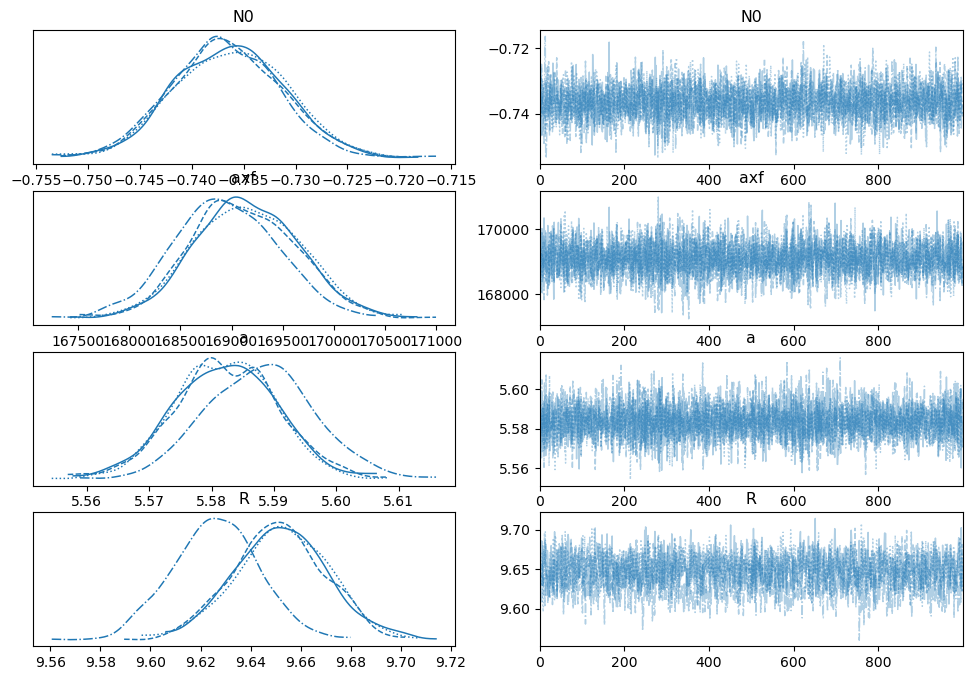

In [59]:
az.plot_trace(traceT,var_names=['N0','axf','a','R'])

In [ ]:
for name in ['10268','10274','8056','8060']:
    
    print(name)
    datad,times=opencube2(name=name,path='../movies')
    scl=1
    
    mask_cube=np.load('./'+name+'/'+name+'_mask2.npy')
    data2=datad[:,:,0:np.shape(mask_cube)[2]]*mask_cube
    vec=datad[:,:,0:np.shape(mask_cube)[2]]*(mask_cube!=1)
    data2=data2[::scl,::scl,:]
    mask_cube=mask_cube[::scl,::scl,:]
    sz2,sz1,nMagnetograms = (np.shape(data2))
    pixsize=1.98*725*1000*100
    pixarea=pixsize*pixsize
    


    bb = [barys(np.abs(data2[:,:,i]),0) for i in range(nMagnetograms)]
    xc2=[bb[i][0] for i in range(nMagnetograms)]
    yc2=[bb[i][1] for i in range(nMagnetograms)]
    
    sg0=np.mean([np.std(vec[:,:,j]*(vec[:,:,j]!=0)) for j in range(nMagnetograms)])
    

    ranges = set_ranges(data2)
    hem=ranges['hem']
        
    apa = np.ravel(data2)
    frame=np.zeros_like(data2)
    for i in range(nMagnetograms):
        frame[:,:,i]=(np.sum(mask_cube,axis=2)>0)
   # frame=np.ones_like(data2)
    apa2=np.ravel(frame)

    ind=(pd.Series(np.abs(apa2) > 0)).to_numpy().nonzero()
    
    for sel in [8,6,4,2]:
        
        ind2=ind[0][::sel]

        sx=np.unravel_index(ind2,(sz2,sz1,nMagnetograms))[1]
        sy=np.unravel_index(ind2,(sz2,sz1,nMagnetograms))[0]
        sz=np.unravel_index(ind2,(sz2,sz1,nMagnetograms))[2]

        cad=1

        TraceS= MODELS()
        traceT = MODELT()
     #   traceTf = MODELTf()
        traceTa = MODELTa()
        traceTaR = MODELTaR()

        #SAVE TO CSV
    #    for path,tr0 in [('T',traceT)]:
        for path,tr0 in [('S_sel'+str(sel)+'_',TraceS),('T_sel'+str(sel)+'_',traceT),('TaR_sel'+str(sel)+'_',traceTaR)]:
            DF=[]

            for i in range(nMagnetograms):
                dic={}


                for tt in ['a','R','axf','da','alpha','f','ar','N0','sg']:

                    rr=tr0.posterior.get(tt)
                    exeption=[]

                    try:

                        pp=1
                        if tt in ['a','R','xc','yc']:
                            pp=scl
                        if tt in ['axf']:
                            pp=scl**2


                        if rr.shape[-1] == nMagnetograms:
                            dic[tt]=pp*rr.values[:,:,i].ravel()

                        else:
                            dic[tt]=pp*rr.values.ravel()

                    except: 
                        exeption.append(tt) 

                dic['mag']=i*np.ones_like(dic['a'])
                dic['xc']=scl*xc2[i]
                dic['yc']=scl*yc2[i]        
          #      dic['flux']=ff[i]*np.ones_like(dic['a'])
                DF.append(pd.DataFrame(dic))


            (pd.concat(DF).assign(Model ='MODEL '+path)).to_csv('./'+name+'/MODEL'+path+'3.csv')


10268
163 165 65
b'21-Jan-2003 14:23:59.130' b'25-Jan-2003 22:23:59.170'
67 64


/home/mpoisson/Work/ARSFIT/IAU-pres/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/IAU-pres/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./10268/trace2_S7_1
./10268/trace2_S7_1_1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./10268/trace2_T7_1
./10268/trace2_T7_1_1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./10268/trace2_Ta7_1
./10268/trace2_Ta7_1_1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./10268/trace2_TaR7_1
./10268/trace2_TaR7_1_1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 87 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./10268/trace2_S7_1
./10268/trace2_S7_1_1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./10268/trace2_T7_1
./10268/trace2_T7_1_1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 73 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./10268/trace2_Ta7_1
./10268/trace2_Ta7_1_1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 86 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./10268/trace2_TaR7_1
./10268/trace2_TaR7_1_1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 89 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./10268/trace2_S7_1
./10268/trace2_S7_1_1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 97 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./10268/trace2_T7_1
./10268/trace2_T7_1_1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 110 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./10268/trace2_Ta7_1
./10268/trace2_Ta7_1_1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 88 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./10268/trace2_TaR7_1
./10268/trace2_TaR7_1_1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 182 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./10268/trace2_S7_1
./10268/trace2_S7_1_1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 167 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./10268/trace2_T7_1
./10268/trace2_T7_1_1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 169 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./10268/trace2_Ta7_1
./10268/trace2_Ta7_1_1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 173 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./10268/trace2_TaR7_1
./10268/trace2_TaR7_1_1
10274
159 159 54
b'1-Feb-2003 19:11:59.260' b'5-Feb-2003 14:26:59.310'
44 94


/home/mpoisson/Work/ARSFIT/IAU-pres/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/IAU-pres/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./10274/trace2_S7_1
./10274/trace2_S7_1_1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./10274/trace2_T7_1
./10274/trace2_T7_1_1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./10274/trace2_Ta7_1
./10274/trace2_Ta7_1_1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./10274/trace2_TaR7_1
./10274/trace2_TaR7_1_1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./10274/trace2_S7_1
./10274/trace2_S7_1_1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./10274/trace2_T7_1
./10274/trace2_T7_1_1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./10274/trace2_Ta7_1
./10274/trace2_Ta7_1_1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./10274/trace2_TaR7_1
./10274/trace2_TaR7_1_1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./10274/trace2_S7_1
./10274/trace2_S7_1_1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./10274/trace2_T7_1
./10274/trace2_T7_1_1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./10274/trace2_Ta7_1
./10274/trace2_Ta7_1_1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 83 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./10274/trace2_TaR7_1
./10274/trace2_TaR7_1_1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 276 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./10274/trace2_S7_1
./10274/trace2_S7_1_1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 155 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./10274/trace2_T7_1
./10274/trace2_T7_1_1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 145 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./10274/trace2_Ta7_1
./10274/trace2_Ta7_1_1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 149 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./10274/trace2_TaR7_1
./10274/trace2_TaR7_1_1
8056
123 133 32
b'24-Jun-1997 16:00:05.380' b'26-Jun-1997 19:12:05.340'
67 97


/home/mpoisson/Work/ARSFIT/IAU-pres/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/IAU-pres/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./8056/trace2_S7_1
./8056/trace2_S7_1_1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./8056/trace2_T7_1
./8056/trace2_T7_1_1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./8056/trace2_Ta7_1
./8056/trace2_Ta7_1_1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./8056/trace2_TaR7_1
./8056/trace2_TaR7_1_1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./8056/trace2_S7_1
./8056/trace2_S7_1_1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./8056/trace2_T7_1
./8056/trace2_T7_1_1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./8056/trace2_Ta7_1
./8056/trace2_Ta7_1_1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./8056/trace2_TaR7_1
./8056/trace2_TaR7_1_1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 87 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./8056/trace2_S7_1
./8056/trace2_S7_1_1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


./8056/trace2_T7_1
./8056/trace2_T7_1_1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, da, alpha]
>BinaryGibbsMetropolis: [ts]


In [46]:
ind[::2]

(array([1760, 1761, 1762, ..., 5277, 5278, 5279]),)

In [29]:
for name in ['10268']:
    
    print(name)
    datad,times=opencube2(name=name,path='../movies')
    scl=1
    
    mask_cube=np.load('./'+name+'/'+name+'_mask2.npy')
    data2=datad[:,:,0:np.shape(mask_cube)[2]]*mask_cube
    vec=datad[:,:,0:np.shape(mask_cube)[2]]*(mask_cube!=1)
    data2=data2[::scl,::scl,:]
    mask_cube=mask_cube[::scl,::scl,:]
    sz2,sz1,nMagnetograms = (np.shape(data2))
    pixsize=1.98*725*1000*100
    pixarea=scl*scl*pixsize*pixsize
    
    ranges = set_ranges(data2)

10268
163 165 65
b'21-Jan-2003 14:23:59.130' b'25-Jan-2003 22:23:59.170'
67 64


In [30]:
ranges

{'a': [0.6842642703552226, 3.0211791651195252],
 'R': [4.553242325089841, 13.659726975269525],
 'axf': [4.6171447290423253e+20, 1.3851434187126976e+21],
 'alpha': [-1.6902566613989634, 1.3097433386010366],
 'xc': [10.322311912820643, 22.73289933217124],
 'yc': [10.546360231978019, 22.213327255439197],
 'hem': 1}

In [28]:
ranges

{'a': [1.4112321264159375, 6.048364526708573],
 'R': [9.07838621379683, 27.235158641390488],
 'axf': [1.848175130988248e+21, 5.544525392964744e+21],
 'alpha': [-1.7061952963612042, 1.2938047036387958],
 'xc': [25.637282110922325, 40.419489064669776],
 'yc': [26.180766328933853, 39.44450213627798],
 'hem': 1}

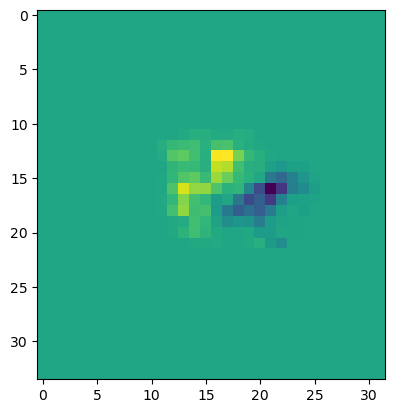

In [32]:
plt.imshow(data2[:,:,10])

# Plot mags

10274
159 159 54
b'1-Feb-2003 19:11:59.260' b'5-Feb-2003 14:26:59.310'
44 94
10268
163 165 65
b'21-Jan-2003 14:23:59.130' b'25-Jan-2003 22:23:59.170'
67 64
8056
123 133 32
b'24-Jun-1997 16:00:05.380' b'26-Jun-1997 19:12:05.340'
67 97
8060
119 147 46
b'7-Jul-1997 14:24:04.080' b'10-Jul-1997 17:36:03.990'
66 80


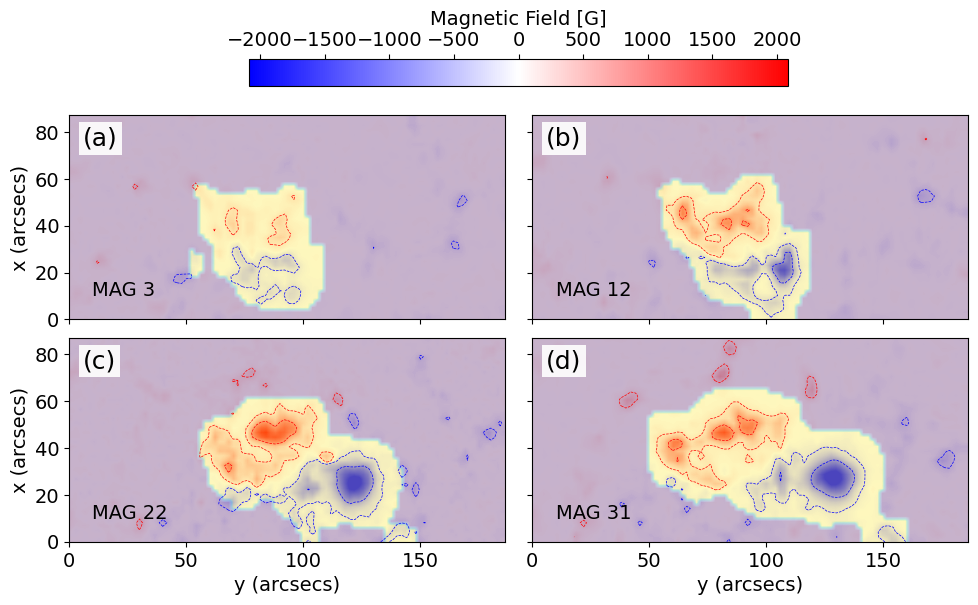

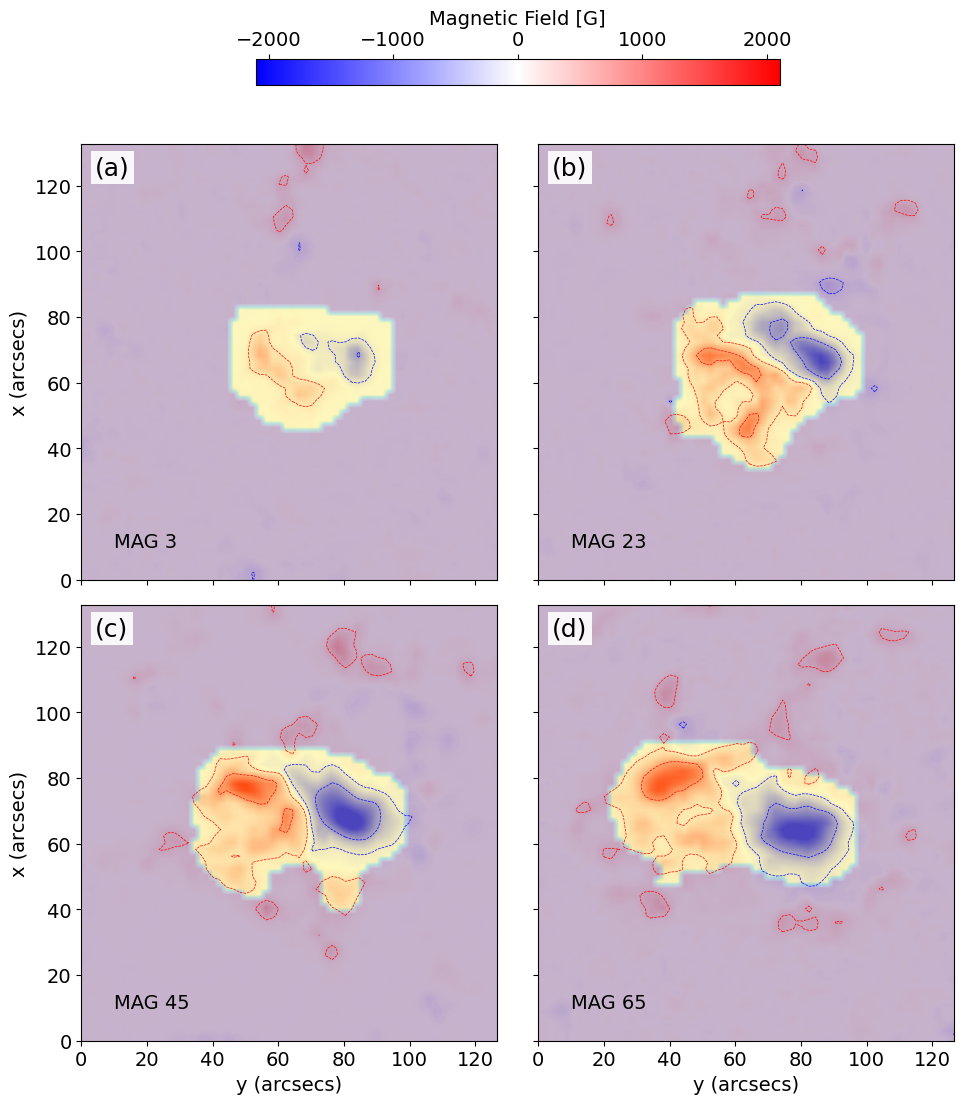

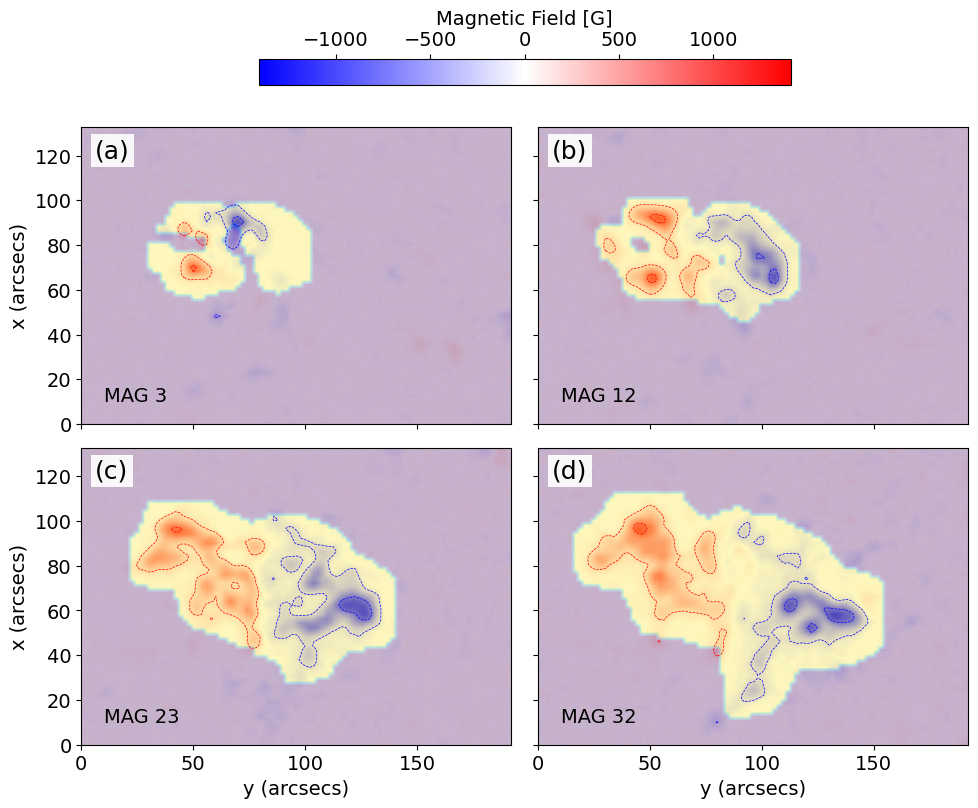

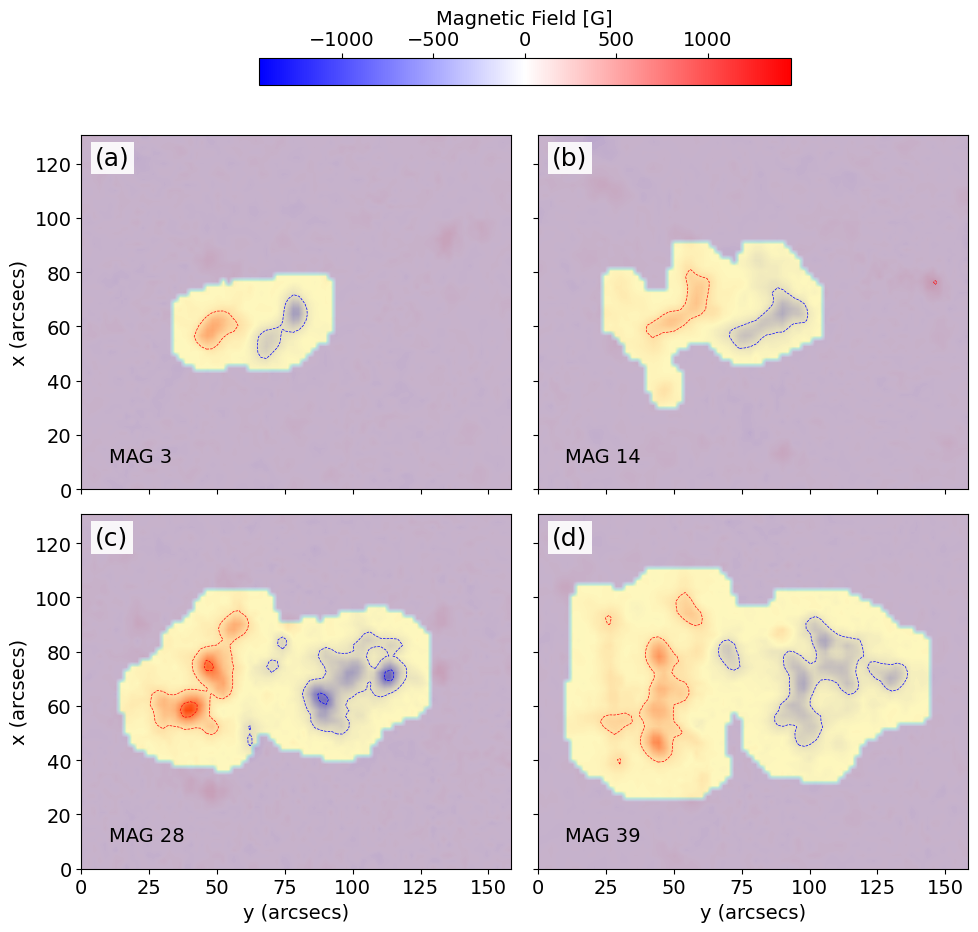

In [162]:
plt.rcParams.update({'font.size':14})


for sc,name in [(6.5,'10274'),(12.5,'10268'),(9,'8056'),(10.5,'8060')]:
    
    print(name)
    datad,times=opencube2(name=name,path='../movies')

    mask_cube=np.load('./'+name+'/'+name+'_mask2.npy')
    data2=datad[:,:,0:np.shape(mask_cube)[2]]*mask_cube
    sz2,sz1,nMagnetograms = (np.shape(data2))
    pixsize=1.98*725*1000*100
    pixarea=pixsize*pixsize
    
    vec=datad[:,:,0:np.shape(mask_cube)[2]]*(mask_cube!=1)
    
    
    f,ax=plt.subplots(figsize=(10,sc),ncols=2,nrows=2,sharex=True,sharey=True)
    
    trans = mtransforms.ScaledTranslation(10/72, -8/72, f.dpi_scale_trans)

    mm=np.max(data2)
    ax=np.ravel(ax)

    samp=[2,round(nMagnetograms/3),round(2*nMagnetograms/3),nMagnetograms-2]

    labela=['(a)','(b)','(c)','(d)']

    for i,mago in enumerate([datad[:,:,j] for j in samp]):


        im1=ax[i].imshow(mago,origin='lower',interpolation='bilinear',
                  cmap='bwr',vmin=-mm,vmax=mm, extent=[0,sz1*1.98,0,sz2*1.98])

        c2=ax[i].imshow(mask_cube[:,:,samp[i]],origin='lower',interpolation='bilinear',
            alpha=0.3, extent=[0,sz1*1.98,0,sz2*1.98])
  
        c1=ax[i].contour(mago,levels=[-1000,-200,200,1000],colors=['b','b','r','r'],
            linewidths=0.5,
            linestyles='dashed', extent=[0,sz1*1.98,0,sz2*1.98])

      #  c2=ax[i].contour(mask_cube[:,:,samp[i]],colors='g',
       #     linewidths=0.5,
        #    linestyles='solid')
   #     if i < 2:
   #         ax[i].xaxis.tick_top()
   #         ax[i].xaxis.set_label_position('top')
        tt1=ax[i].text(10,10,'MAG '+str(samp[i]+1))
        
        ax[i].text(0.0, 1.0, letters[i], transform=ax[i].transAxes + trans,
        fontsize=18, verticalalignment='top', 
        #fontfamily='serif',
        bbox=dict(facecolor='white', edgecolor='none', pad=3.0,alpha=0.9))  

    for i in [0,2]:
        ax[i].set_ylabel('x (arcsecs)')
    for i in [2,3]:
        ax[i].set_xlabel('y (arcsecs)')

    f.tight_layout()
  #  plt.subplots_adjust(wspace=0, hspace=0)
    f.colorbar(im1, ax=ax[:], shrink=0.6, location='top',label='Magnetic Field [G]')
#    divider = make_axes_locatable(ax[1])

 #   cax = divider.append_axes('right', size='5%', pad=0.05)

  #  f.colorbar(im1, cax=cax, orientation='vertical')
  #  f.tight_layout()


  #  plt.savefig('./'+name+'_panels.pdf',dpi=300,bbox_inches='tight')

# MODPLOT

10274
159 159 54
b'1-Feb-2003 19:11:59.260' b'5-Feb-2003 14:26:59.310'
44 94
10268
163 165 65
b'21-Jan-2003 14:23:59.130' b'25-Jan-2003 22:23:59.170'
67 64
8056
123 133 32
b'24-Jun-1997 16:00:05.380' b'26-Jun-1997 19:12:05.340'
67 97
8060
119 147 46
b'7-Jul-1997 14:24:04.080' b'10-Jul-1997 17:36:03.990'
66 80


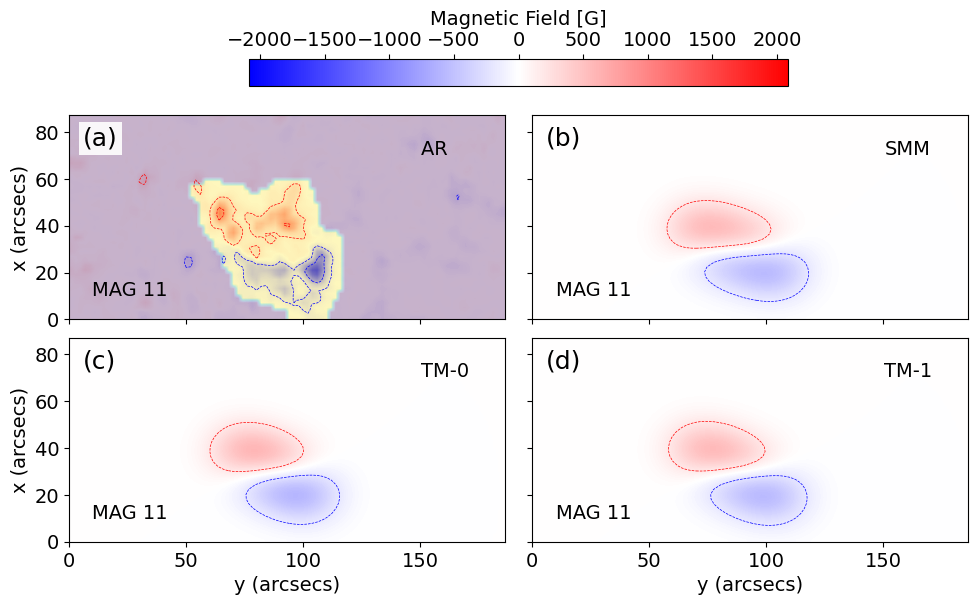

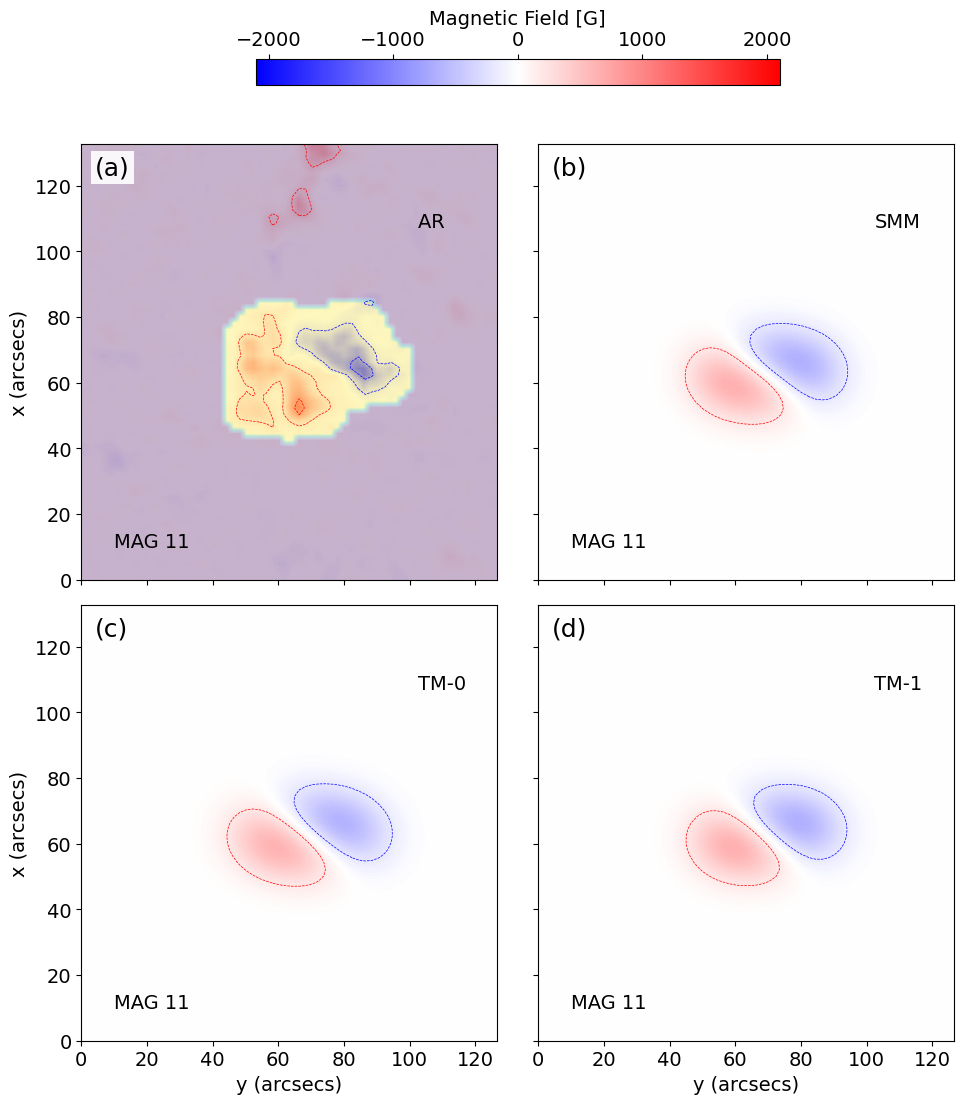

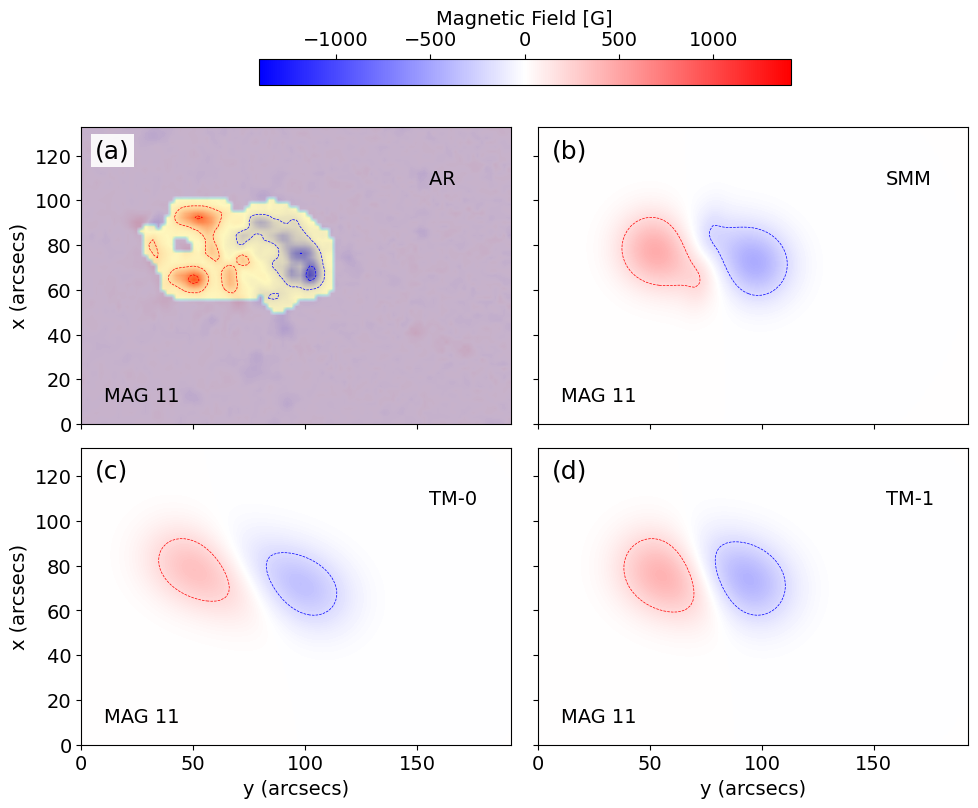

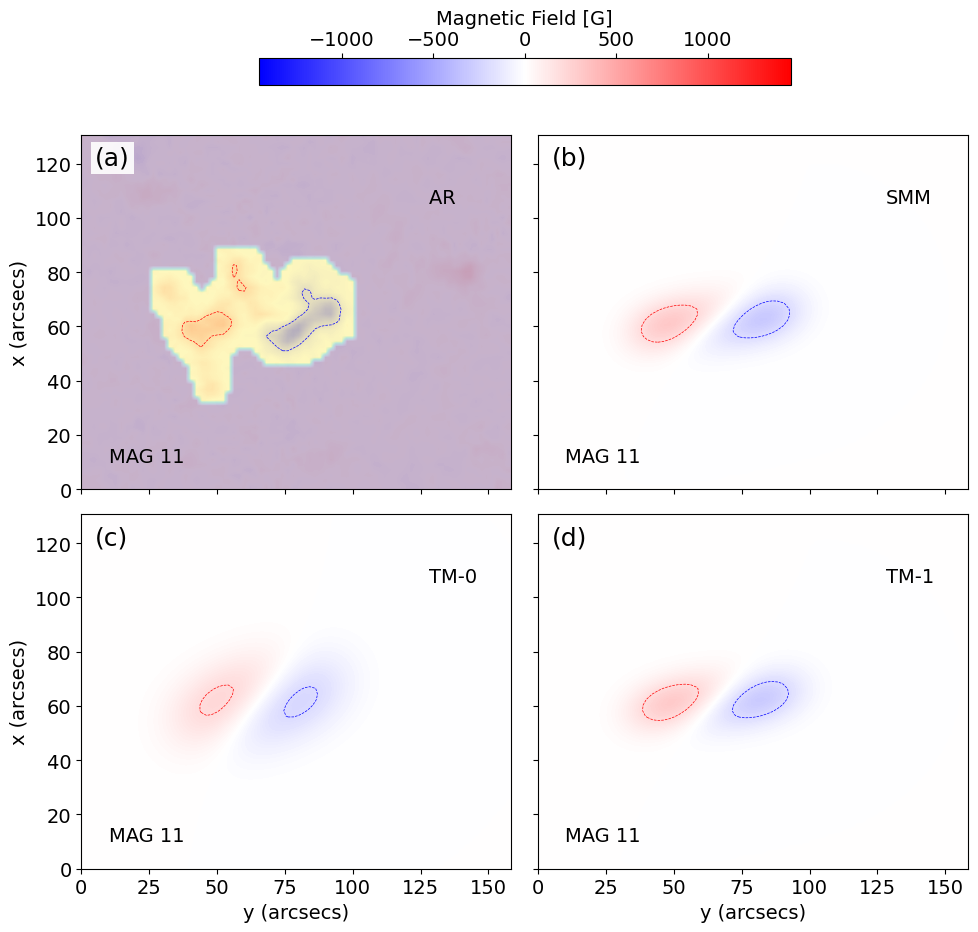

In [178]:
plt.rcParams.update({'font.size':14})


for sc,name in [(6.5,'10274'),(12.5,'10268'),(9,'8056'),(10.5,'8060')]:
    
    print(name)
    datad,times=opencube2(name=name,path='../movies')

    mask_cube=np.load('./'+name+'/'+name+'_mask2.npy')
    cube0=np.load('./'+name+'/cube0.npy')
    cubeS=np.load('./'+name+'/cubeS.npy')
    cube2=np.load('./'+name+'/cube2.npy')

    data2=datad[:,:,0:np.shape(mask_cube)[2]]*mask_cube
    sz2,sz1,nMagnetograms = (np.shape(data2))
    pixsize=1.98*725*1000*100
    pixarea=pixsize*pixsize
    
    vec=datad[:,:,0:np.shape(mask_cube)[2]]*(mask_cube!=1)
    
    
    f,ax=plt.subplots(figsize=(10,sc),ncols=2,nrows=2,sharex=True,sharey=True)
    
    trans = mtransforms.ScaledTranslation(10/72, -8/72, f.dpi_scale_trans)

    mm=np.max(data2)
    ax=np.ravel(ax)

    samp=10

    labela=['(a)','(b)','(c)','(d)']
    modlab=['AR ','SMM','TM-0','TM-1']

    for i,mago in enumerate([datad[:,:,samp],cubeS[:,:,samp],cube0[:,:,samp],cube2[:,:,samp]]):


        im1=ax[i].imshow(mago,origin='lower',interpolation='bilinear',
                  cmap='bwr',vmin=-mm,vmax=mm, extent=[0,sz1*1.98,0,sz2*1.98])

  
        c1=ax[i].contour(mago,levels=[-1000,-200,200,1000],colors=['b','b','r','r'],
            linewidths=0.5,
            linestyles='dashed', extent=[0,sz1*1.98,0,sz2*1.98])

      #  c2=ax[i].contour(mask_cube[:,:,samp[i]],colors='g',
       #     linewidths=0.5,
        #    linestyles='solid')
   #     if i < 2:
   #         ax[i].xaxis.tick_top()
   #         ax[i].xaxis.set_label_position('top')
        tt1=ax[i].text(10,10,'MAG '+str(samp+1))
        tt2=ax[i].text(1.6*sz1,1.6*sz2,modlab[i])
        
        ax[i].text(0.0, 1.0, letters[i], transform=ax[i].transAxes + trans,
        fontsize=18, verticalalignment='top', 
        #fontfamily='serif',
        bbox=dict(facecolor='white', edgecolor='none', pad=3.0,alpha=0.9))  

    for i in [0,2]:
        ax[i].set_ylabel('x (arcsecs)')
    for i in [2,3]:
        ax[i].set_xlabel('y (arcsecs)')

    c2=ax[0].imshow(mask_cube[:,:,samp],origin='lower',interpolation='bilinear',
        alpha=0.3, extent=[0,sz1*1.98,0,sz2*1.98])

    f.tight_layout()
  #  plt.subplots_adjust(wspace=0, hspace=0)
    f.colorbar(im1, ax=ax[:], shrink=0.6, location='top',label='Magnetic Field [G]')
#    divider = make_axes_locatable(ax[1])

 #   cax = divider.append_axes('right', size='5%', pad=0.05)

  #  f.colorbar(im1, cax=cax, orientation='vertical')
  #  f.tight_layout()


  #  plt.savefig('./'+name+'_panels.pdf',dpi=300,bbox_inches='tight')

In [182]:
import matplotlib.animation as animation
#animation.rcParams['animation.writer'] = 'ffmpeg'
from IPython.display import HTML
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['animation.ffmpeg_path'] = u'/home/mpoisson/anaconda3/bin/ffmpeg'   

10274
159 159 54
b'1-Feb-2003 19:11:59.260' b'5-Feb-2003 14:26:59.310'
44 94
10268
163 165 65
b'21-Jan-2003 14:23:59.130' b'25-Jan-2003 22:23:59.170'
67 64
8056
123 133 32
b'24-Jun-1997 16:00:05.380' b'26-Jun-1997 19:12:05.340'
67 97


/tmp/ipykernel_26553/2673926886.py:50: UserWarning: No contour levels were found within the data range.
  c3=ax[2].contour(cube0[:,:,samp],levels=[-1000,-200,200,1000],colors=['b','b','r','r'],
/tmp/ipykernel_26553/2673926886.py:108: UserWarning: No contour levels were found within the data range.
  c3=ax[2].contour(cube0[:,:,samp],levels=[-1000,-200,200,1000],colors=['b','b','r','r'],


8060
119 147 46
b'7-Jul-1997 14:24:04.080' b'10-Jul-1997 17:36:03.990'
66 80


/tmp/ipykernel_26553/2673926886.py:50: UserWarning: No contour levels were found within the data range.
  c3=ax[2].contour(cube0[:,:,samp],levels=[-1000,-200,200,1000],colors=['b','b','r','r'],
/tmp/ipykernel_26553/2673926886.py:108: UserWarning: No contour levels were found within the data range.
  c3=ax[2].contour(cube0[:,:,samp],levels=[-1000,-200,200,1000],colors=['b','b','r','r'],


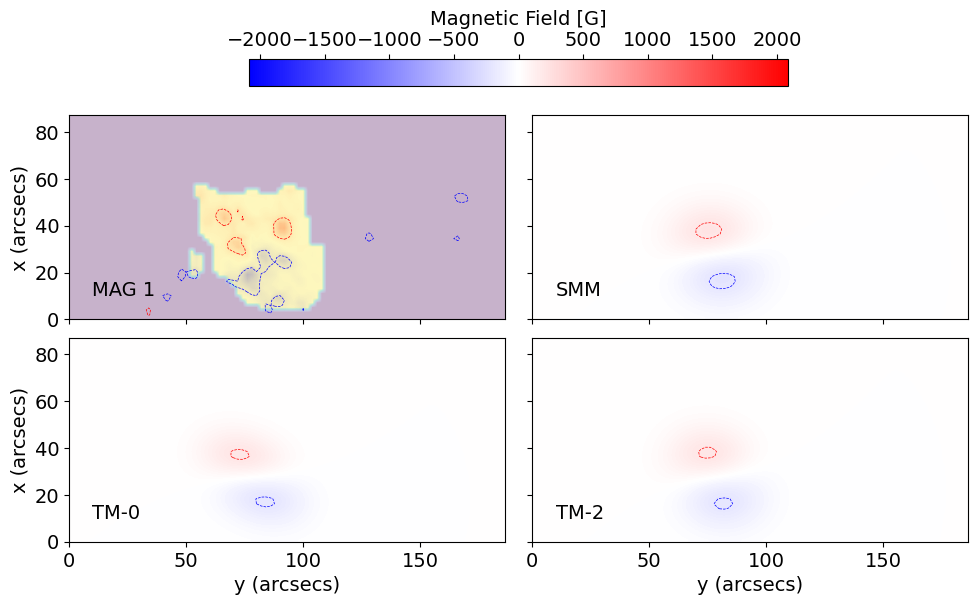

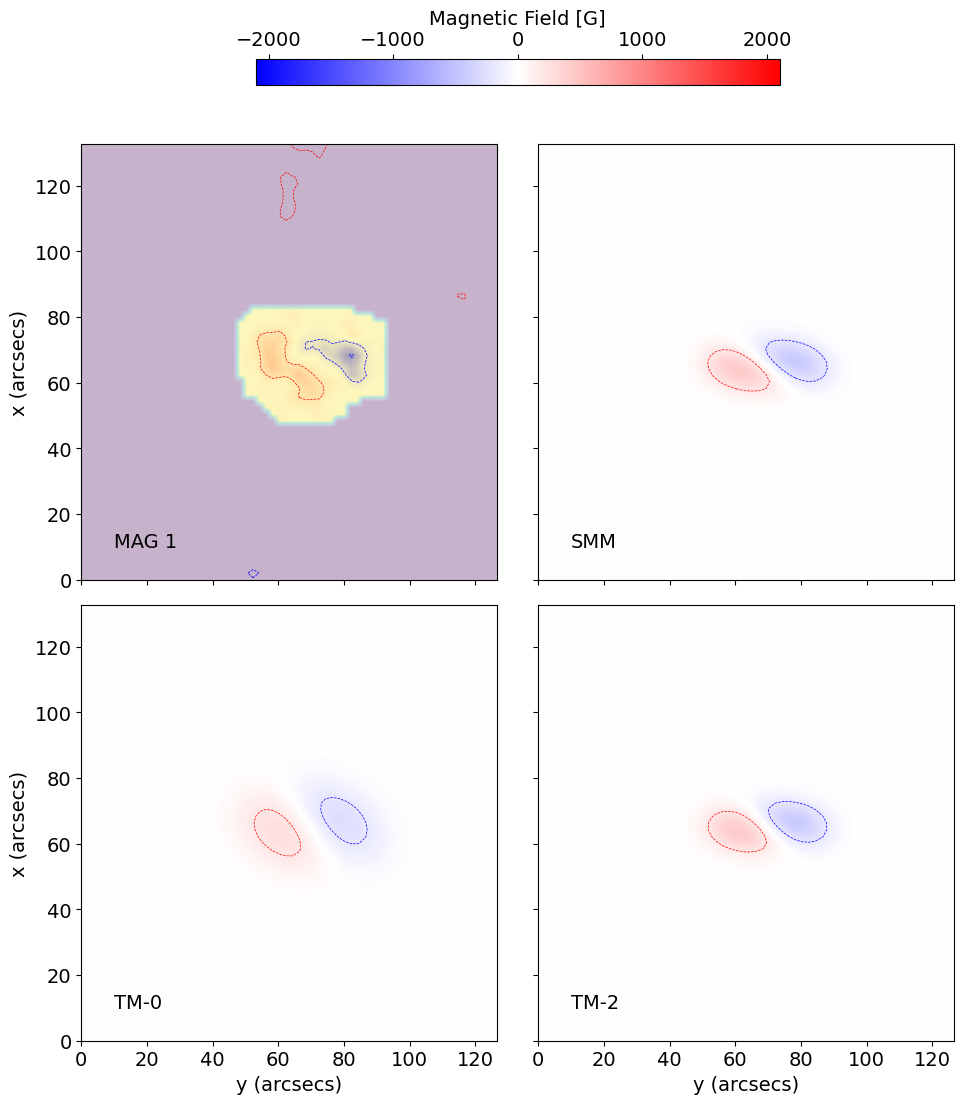

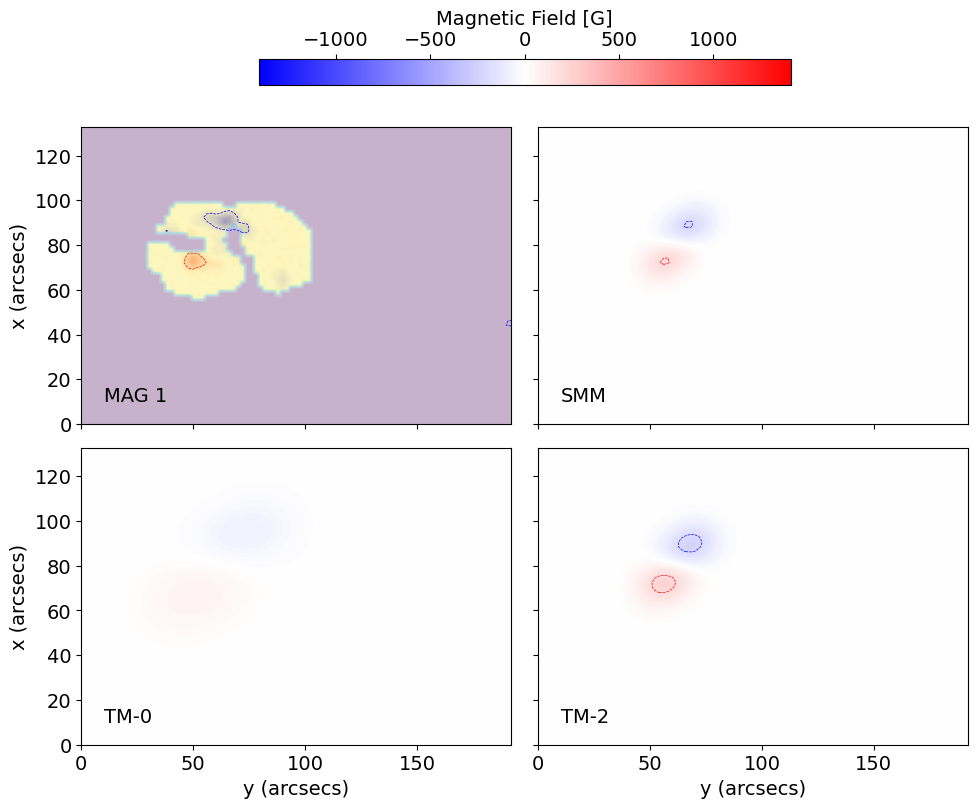

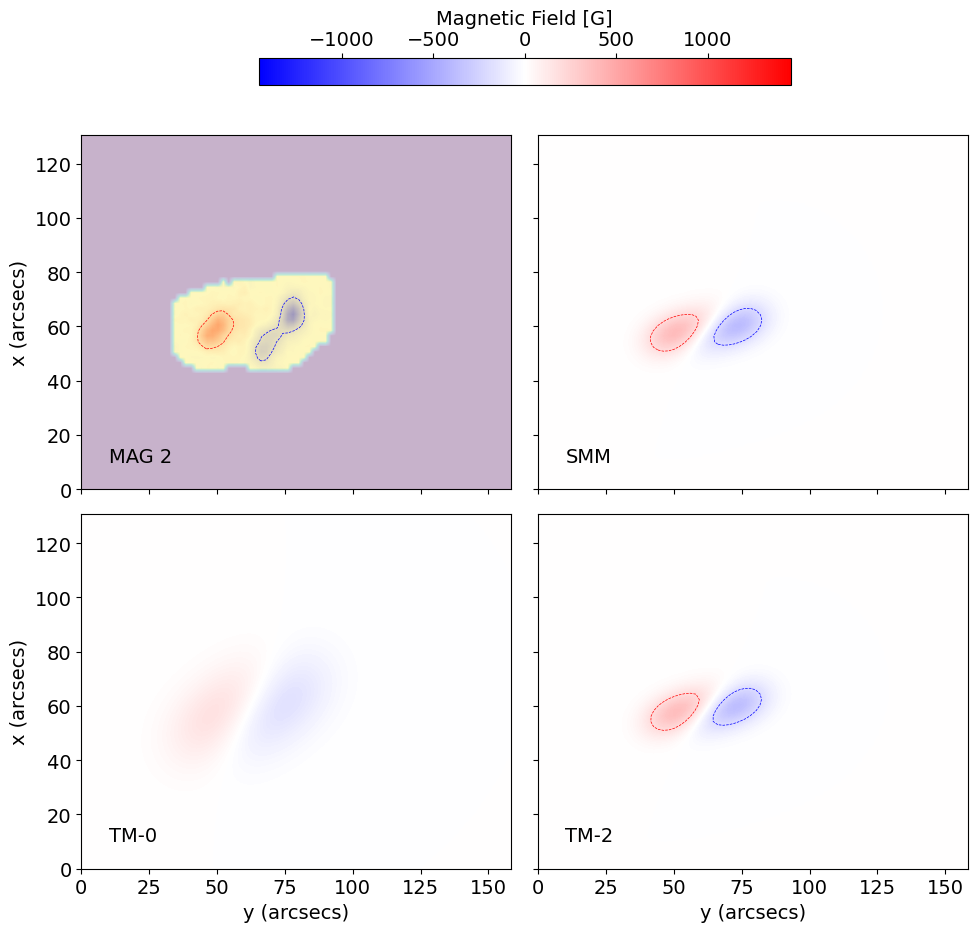

In [ ]:
plt.rcParams.update({'font.size':14})


for sc,name in [(6.5,'10274'),(12.5,'10268'),(9,'8056'),(10.5,'8060')]:
    
    print(name)
    datad,times=opencube2(name=name,path='../movies')

    mask_cube=np.load('./'+name+'/'+name+'_mask2.npy')
    cube0=np.load('./'+name+'/cube0.npy')
    cubeS=np.load('./'+name+'/cubeS.npy')
    cube2=np.load('./'+name+'/cube2.npy')

    data2=datad[:,:,0:np.shape(mask_cube)[2]]*mask_cube
    sz2,sz1,nMagnetograms = (np.shape(data2))
    pixsize=1.98*725*1000*100
    pixarea=pixsize*pixsize
    
    vec=datad[:,:,0:np.shape(mask_cube)[2]]*(mask_cube!=1)
    
 
    f,ax=plt.subplots(figsize=(10,sc),ncols=2,nrows=2,sharex=True,sharey=True)
    
    trans = mtransforms.ScaledTranslation(10/72, -8/72, f.dpi_scale_trans)

    mm=np.max(data2)
    ax=np.ravel(ax)

    samp=0

    labela=['(a)','(b)','(c)','(d)']
    modlab=['AR ','SMM','TM-0','TM-1']



    im1=ax[0].imshow(data2[:,:,samp],origin='lower',interpolation='bilinear',cmap='bwr',vmin=-mm,vmax=mm, extent=[0,sz1*1.98,0,sz2*1.98])
    im2=ax[1].imshow(cubeS[:,:,samp],origin='lower',interpolation='bilinear',cmap='bwr',vmin=-mm,vmax=mm, extent=[0,sz1*1.98,0,sz2*1.98])
    im3=ax[2].imshow(cube0[:,:,samp],origin='lower',interpolation='bilinear',cmap='bwr',vmin=-mm,vmax=mm, extent=[0,sz1*1.98,0,sz2*1.98])
    im4=ax[3].imshow(cube2[:,:,samp],origin='lower',interpolation='bilinear',cmap='bwr',vmin=-mm,vmax=mm, extent=[0,sz1*1.98,0,sz2*1.98])

  
    c1=ax[0].contour(data2[:,:,samp],levels=[-1000,-200,200,1000],colors=['b','b','r','r'],
        linewidths=0.5,
        linestyles='dashed', extent=[0,sz1*1.98,0,sz2*1.98])

    c2=ax[1].contour(cubeS[:,:,samp],levels=[-1000,-200,200,1000],colors=['b','b','r','r'],
        linewidths=0.5,
        linestyles='dashed', extent=[0,sz1*1.98,0,sz2*1.98])
    
    c3=ax[2].contour(cube0[:,:,samp],levels=[-1000,-200,200,1000],colors=['b','b','r','r'],
        linewidths=0.5,
        linestyles='dashed', extent=[0,sz1*1.98,0,sz2*1.98])
    
    c4=ax[3].contour(cube2[:,:,samp],levels=[-1000,-200,200,1000],colors=['b','b','r','r'],
        linewidths=0.5,
        linestyles='dashed', extent=[0,sz1*1.98,0,sz2*1.98])    
      #  c2=ax[i].contour(mask_cube[:,:,samp[i]],colors='g',
       #     linewidths=0.5,
        #    linestyles='solid')
   #     if i < 2:
   #         ax[i].xaxis.tick_top()
   #         ax[i].xaxis.set_label_position('top')
    tt1=ax[0].text(10,10,'MAG '+str(samp+1))
    tt2=ax[1].text(10,10,'SMM')
    tt3=ax[2].text(10,10,'TM-0')
    tt4=ax[3].text(10,10,'TM-2')
           

    for i in [0,2]:
        ax[i].set_ylabel('x (arcsecs)')
    for i in [2,3]:
        ax[i].set_xlabel('y (arcsecs)')

    c5=ax[0].imshow(mask_cube[:,:,samp],origin='lower',interpolation='bilinear',
        alpha=0.3, extent=[0,sz1*1.98,0,sz2*1.98])

    f.tight_layout()
  #  plt.subplots_adjust(wspace=0, hspace=0)
    f.colorbar(im1, ax=ax[:], shrink=0.6, location='top',label='Magnetic Field [G]')
    
    
    def update(*args):
        global samp,im1,im2,im3,im4,c1,c2,c3,c4,c5,cad,datad,cube0,mask_cube,cubeS,cube2,tt1

        im1.set_array(data2[:,:,samp])
        im2.set_array(cubeS[:,:,samp])
        im3.set_array(cube0[:,:,samp])
        im4.set_array(cube2[:,:,samp])
        c5.set_array(mask_cube[:,:,samp])

        for h in c1.collections:
            h.remove()
        for h in c2.collections:
            h.remove()
        for h in c3.collections:
            h.remove()
        for h in c4.collections:
            h.remove()

        c1=ax[0].contour(datad[:,:,samp],levels=[-1000,-200,200,1000],colors=['b','b','r','r'],
            linewidths=0.5,
            linestyles='dashed', extent=[0,sz1*1.98,0,sz2*1.98])

        c2=ax[1].contour(cubeS[:,:,samp],levels=[-1000,-200,200,1000],colors=['b','b','r','r'],
            linewidths=0.5,
            linestyles='dashed', extent=[0,sz1*1.98,0,sz2*1.98])

        c3=ax[2].contour(cube0[:,:,samp],levels=[-1000,-200,200,1000],colors=['b','b','r','r'],
            linewidths=0.5,
            linestyles='dashed', extent=[0,sz1*1.98,0,sz2*1.98])

        c4=ax[3].contour(cube2[:,:,samp],levels=[-1000,-200,200,1000],colors=['b','b','r','r'],
            linewidths=0.5,
            linestyles='dashed', extent=[0,sz1*1.98,0,sz2*1.98])  

        tt1.set_text('MAG '+str(samp+1))

        samp += 1
        samp %= nMagnetograms

        return im1,im2,im3,im4,c1,c2,c3,c4,c5,tt1

    ani = animation.FuncAnimation(f, update, np.shape(data2)[2], blit=False, interval=100,
                                  repeat=False, save_count=150)

    writervideo = animation.FFMpegWriter(fps=1)

    ani.save('./'+name+'/'+name+'-mov.mp4',writer=writervideo,dpi=300)
#    divider = make_axes_locatable(ax[1])

 #   cax = divider.append_axes('right', size='5%', pad=0.05)

  #  f.colorbar(im1, cax=cax, orientation='vertical')
  #  f.tight_layout()


  #  plt.savefig('./'+name+'_panels.pdf',dpi=300,bbox_inches='tight')

# Plot fluxes

In [2]:
letters=['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)']

letters2=['(a-1)','(a-2)','(b-1)','(b-2)','(c-1)','(c-2)','(d-1)','(d-2)']


labelx={'a':'$a$','R':'$R$','da':'$d_0$','N0':'$N_t$',
        'B0':'$B_0$','xc':'$x_c$','yc':'$y_c$',
        'alpha':r'$\phi$','sg':r'$\sigma$',
        'axf':'$\Phi_A$','Hel':'Magnetic Helicity','f':'f','ar':'$a_r$'}

unitsx={'a':'[pixels]','R':'[pixels]','da':'','N0':'',
        'B0':'[G]','xc':'[pixels]','yc':'[pixels]',
        'alpha':'[deg]','sg':'[G]','axf':'[Mx]',
        'Hel':'[Mx$^2$]','f':'','ar':''}

pixsize=1.98*725*1000*100
pixarea=pixsize*pixsize

10274
159 159 54
b'1-Feb-2003 19:11:59.260' b'5-Feb-2003 14:26:59.310'
44 94
10268
163 165 65
b'21-Jan-2003 14:23:59.130' b'25-Jan-2003 22:23:59.170'
67 64
8056
123 133 32
b'24-Jun-1997 16:00:05.380' b'26-Jun-1997 19:12:05.340'
67 97
8060
119 147 46
b'7-Jul-1997 14:24:04.080' b'10-Jul-1997 17:36:03.990'
66 80


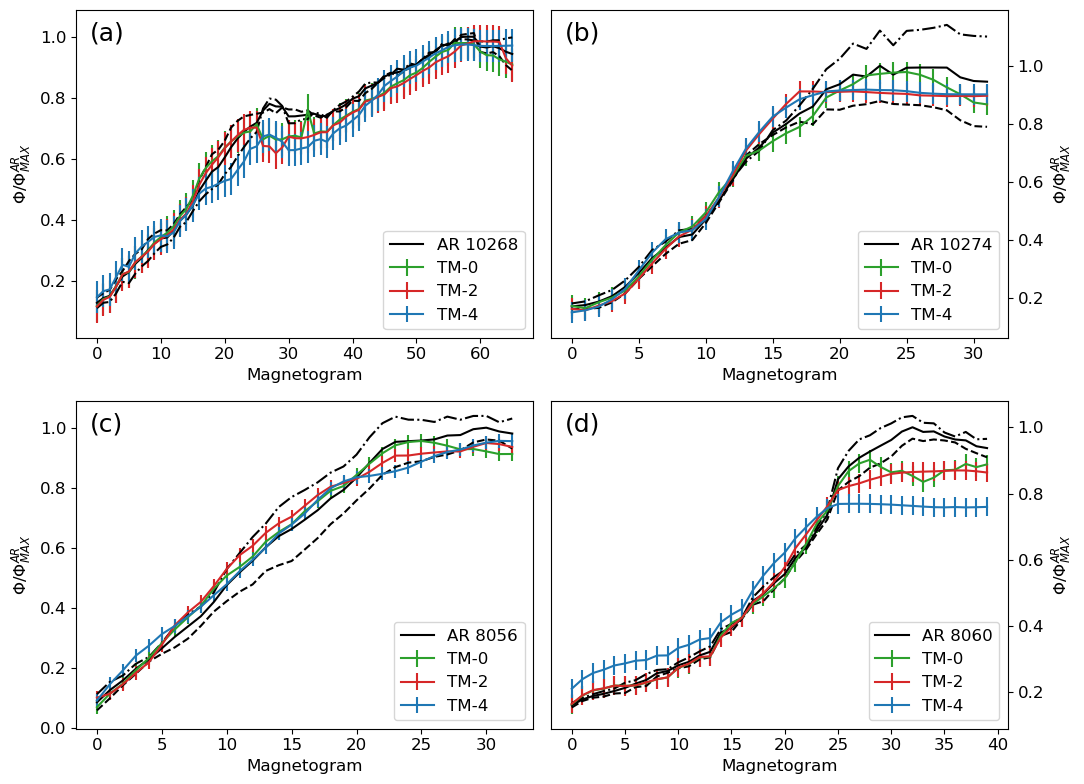

In [4]:
plt.rcParams.update({'font.size':12})

f,ax = plt.subplots(figsize=(11,8),ncols=2,nrows=2)

trans = mtransforms.ScaledTranslation(10/72, -8/72, f.dpi_scale_trans)

ax=np.ravel(ax)

for sc,name in [(1,'10274'),(0,'10268'),(2,'8056'),(3,'8060')]:
    
    print(name)
    datad,times=opencube2(name=name,path='../movies')

    mask_cube=np.load('./'+name+'/'+name+'_mask2.npy')
    cube0=np.load('./'+name+'/cube0.npy')
    cubeS=np.load('./'+name+'/cubeS.npy')
    cube2=np.load('./'+name+'/cube2.npy')
    
    vec=datad[:,:,0:np.shape(mask_cube)[2]]*(mask_cube!=1)
    

    data2=datad[:,:,0:np.shape(mask_cube)[2]]*mask_cube
    sz2,sz1,nMagnetograms = (np.shape(data2))
    pixsize=1.98*725*1000*100
    pixarea=pixsize*pixsize
    sg0=np.mean([np.std(vec[:,:,j]*(vec[:,:,j]!=0)) for j in range(nMagnetograms)])
    
    fx=np.sum(np.abs(data2)/2,axis=(0,1))
    fxp=np.sum(np.abs(data2*(data2>0)),axis=(0,1))
    fxn=np.sum(np.abs(data2*(data2<0)),axis=(0,1))
    mfx=np.max(fx)
    
    errS=sg0*np.sqrt(np.sum(mask_cube > 0))/mfx
    

#    plt.errorbar(range(nMagnetograms),np.sum(np.abs(cubeS/mfx)/2,axis=(0,1)),yerr=np.sum(np.abs(50*mask_cube/(np.sqrt(np.sum(mask_cube,axis=(0,1)))*mfx)),axis=(0,1)),color='tab:green',label='SMM')
    ax[sc].errorbar(range(nMagnetograms),np.sum(np.abs(cubeS/mfx)/2,axis=(0,1)),yerr=errS,color='tab:green',label='TM-0')
    ax[sc].errorbar(range(nMagnetograms),np.sum(np.abs(cube2/mfx)/2,axis=(0,1)),yerr=errS,color='tab:red',label='TM-2')
    ax[sc].errorbar(range(nMagnetograms),np.sum(np.abs(cube0/mfx)/2,axis=(0,1)),yerr=errS,color='tab:blue',label='TM-4')

    ax[sc].plot(fx/mfx,color='black',label='AR '+name)
    ax[sc].plot(fxp/mfx,color='black',linestyle='--')
    ax[sc].plot(fxn/mfx,color='black',linestyle='-.') 

    #plt.plot(np.sum(np.abs(cube0/mfx)/2,axis=(0,1)),color='tab:blue',label='TM-0')
#    plt.plot(np.sum(np.abs(cube2/mfx)/2,axis=(0,1)),color='tab:red',label='TM-2')
    ax[sc].legend(loc='lower right')
 #   ax[sc].set_title('AR '+name)
    ax[sc].text(0.0, 1.0, letters[sc], transform=ax[sc].transAxes + trans,
    fontsize=18, verticalalignment='top', 
    #fontfamily='serif',
    bbox=dict(facecolor='white', edgecolor='none', pad=3.0,alpha=0.5))
    
    if (sc % 2) != 0: 
        ax[sc].yaxis.tick_right()
        ax[sc].yaxis.set_label_position('right')
    

for ax1 in ax:
    ax1.set_xlabel('Magnetogram')
    ax1.set_ylabel('$ \Phi / \Phi_{MAX}^{AR}$')
    
f.tight_layout()

#plt.savefig('params-plot-land-resolution.png',dpi=300,bbox_inches='tight')
plt.savefig('fluxes.pdf',dpi=300,bbox_inches='tight')

# Estim sigma

In [13]:
letters=['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)']

letters2=['(a-1)','(a-2)','(b-1)','(b-2)','(c-1)','(c-2)','(d-1)','(d-2)']


labelx={'a':'$a$','R':'$R$','da':'$d_0$','N0':'$N_t$',
        'B0':'$B_0$','xc':'$x_c$','yc':'$y_c$',
        'alpha':r'$\phi$','sg':r'$\sigma$',
        'axf':'$\Phi_A$','Hel':'Magnetic Helicity','f':'f','ar':'$a_r$'}

unitsx={'a':'[pixels]','R':'[pixels]','da':'','N0':'',
        'B0':'[G]','xc':'[pixels]','yc':'[pixels]',
        'alpha':'[deg]','sg':'[G]','axf':'[Mx]',
        'Hel':'[Mx$^2$]','f':'','ar':''}

pixsize=1.98*725*1000*100
pixarea=pixsize*pixsize

10274
159 159 54
b'1-Feb-2003 19:11:59.260' b'5-Feb-2003 14:26:59.310'
44 94
10268
163 165 65
b'21-Jan-2003 14:23:59.130' b'25-Jan-2003 22:23:59.170'
67 64
8056
123 133 32
b'24-Jun-1997 16:00:05.380' b'26-Jun-1997 19:12:05.340'
67 97
8060
119 147 46
b'7-Jul-1997 14:24:04.080' b'10-Jul-1997 17:36:03.990'
66 80


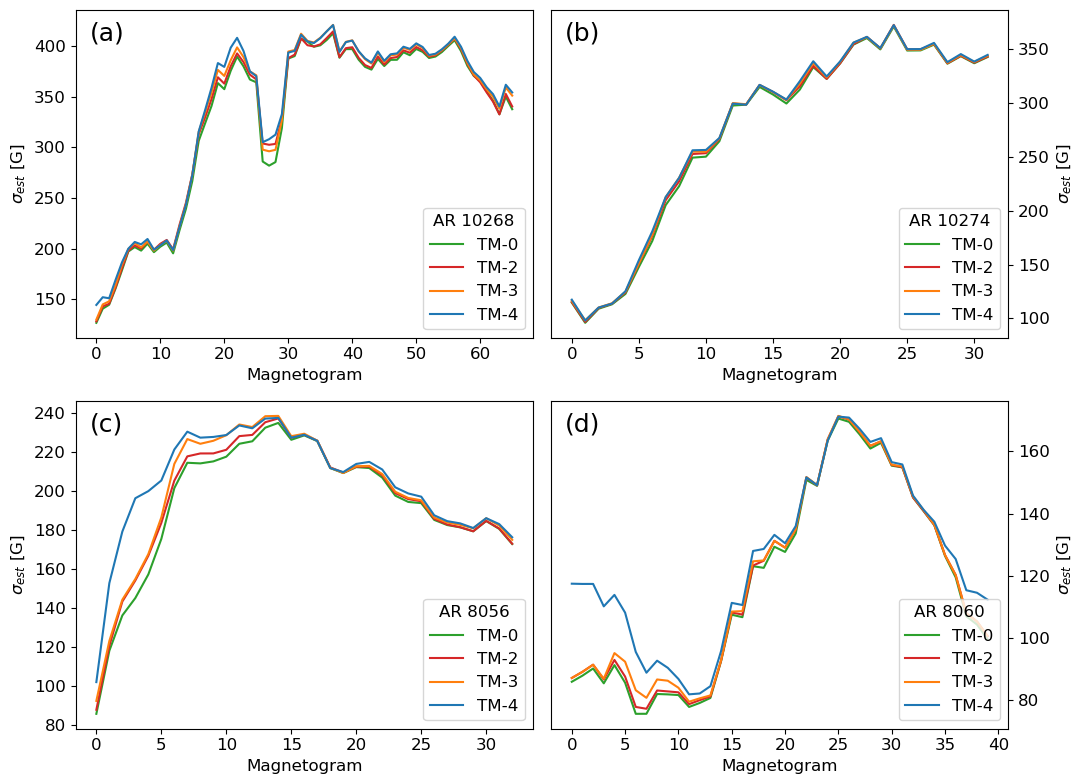

In [44]:
plt.rcParams.update({'font.size':12})

f,ax = plt.subplots(figsize=(11,8),ncols=2,nrows=2)

trans = mtransforms.ScaledTranslation(10/72, -8/72, f.dpi_scale_trans)

ax=np.ravel(ax)

for sc,name in [(1,'10274'),(0,'10268'),(2,'8056'),(3,'8060')]:
    
    print(name)
    datad,times=opencube2(name=name,path='../movies')

    mask_cube=np.load('./'+name+'/'+name+'_mask2.npy')
    cube0=np.load('./'+name+'/cube0.npy')
    cubeS=np.load('./'+name+'/cubeS.npy')
    cube2=np.load('./'+name+'/cube2.npy')
    cube1=np.load('./'+name+'/cube1.npy')
    
    vec=datad[:,:,0:np.shape(mask_cube)[2]]*(mask_cube!=1)
    

    data2=datad[:,:,0:np.shape(mask_cube)[2]]*mask_cube
    
    mmask=np.sum(mask_cube,axis=2) > 0

    
    
    sz2,sz1,nMagnetograms = (np.shape(data2))
    pixsize=1.98*725*1000*100
    pixarea=pixsize*pixsize
    sg0=np.mean([np.std(vec[:,:,j]*(vec[:,:,j]!=0)) for j in range(nMagnetograms)])
    sgcube0=((cube0-data2)**2)
    sgcubeS=((cubeS-data2)**2)
    sgcube2=((cube2-data2)**2)
    sgcube1=((cube1-data2)**2)
    mmask=np.zeros_like(data2)
    for i in range(nMagnetograms):
        mmask[:,:,i]=np.sum(mask_cube,axis=2) > 0 
    mmask=mask_cube
    
    ax[sc].plot(np.sqrt(np.sum(mmask*sgcubeS,axis=(0,1))/np.sum(mmask,axis=(0,1))),color='tab:green',label='TM-0')
    ax[sc].plot(np.sqrt(np.sum(mmask*sgcube2,axis=(0,1))/np.sum(mmask,axis=(0,1))),color='tab:red',label='TM-2')
    ax[sc].plot(np.sqrt(np.sum(mmask*sgcube1,axis=(0,1))/np.sum(mmask,axis=(0,1))),color='tab:orange',label='TM-3')
    ax[sc].plot(np.sqrt(np.sum(mmask*sgcube0,axis=(0,1))/np.sum(mmask,axis=(0,1))),color='tab:blue',label='TM-4')

 #   ax[sc].plot(np.sqrt(np.sum((data2>0)*mmask*sgcubeS,axis=(0,1))/np.sum((data2>0)*mmask,axis=(0,1))),color='tab:green',linestyle='dashed')
 #   ax[sc].plot(np.sqrt(np.sum((data2>0)*mmask*sgcube2,axis=(0,1))/np.sum((data2>0)*mmask,axis=(0,1))),color='tab:red',linestyle='dashed')
 #   ax[sc].plot(np.sqrt(np.sum((data2>0)*mmask*sgcube1,axis=(0,1))/np.sum((data2>0)*mmask,axis=(0,1))),color='tab:orange',linestyle='dashed')
 #   ax[sc].plot(np.sqrt(np.sum((data2>0)*mmask*sgcube0,axis=(0,1))/np.sum((data2>0)*mmask,axis=(0,1))),color='tab:blue',linestyle='dashed')

 #   ax[sc].plot(np.sqrt(np.sum((data2<0)*mmask*sgcubeS,axis=(0,1))/np.sum((data2<0)*mmask,axis=(0,1))),color='tab:green',linestyle='dotted')
 #   ax[sc].plot(np.sqrt(np.sum((data2<0)*mmask*sgcube2,axis=(0,1))/np.sum((data2<0)*mmask,axis=(0,1))),color='tab:red',linestyle='dotted')
 #   ax[sc].plot(np.sqrt(np.sum((data2<0)*mmask*sgcube1,axis=(0,1))/np.sum((data2<0)*mmask,axis=(0,1))),color='tab:orange',linestyle='dotted')
 #   ax[sc].plot(np.sqrt(np.sum((data2<0)*mmask*sgcube0,axis=(0,1))/np.sum((data2<0)*mmask,axis=(0,1))),color='tab:blue',linestyle='dotted')
    
    ax[sc].legend(title='AR '+name,loc='lower right')
    
    ax[sc].text(0.0, 1.0, letters[sc], transform=ax[sc].transAxes + trans,
    fontsize=18, verticalalignment='top', 
    #fontfamily='serif',
    bbox=dict(facecolor='white', edgecolor='none', pad=3.0,alpha=0.5))
    
    if (sc % 2) != 0: 
        ax[sc].yaxis.tick_right()
        ax[sc].yaxis.set_label_position('right')
        
    ax[sc].set_xlabel('Magnetogram')
    ax[sc].set_ylabel(r'$\sigma_{est}$ [G]')
        
f.tight_layout()

plt.savefig('estim-sigma.pdf',dpi=300,bbox_inches='tight')

# Extra

In [188]:
nMagnetograms

32

In [8]:
name='8060'
mask_cube=np.load('./'+name+'/'+name+'_mask2.npy')
datad,times=opencube2(name=name,path='../movies')
data2=datad[:,:,0:np.shape(mask_cube)[2]]*mask_cube
sz2,sz1,nMagnetograms = (np.shape(data2))

119 147 46
b'7-Jul-1997 14:24:04.080' b'10-Jul-1997 17:36:03.990'
66 80


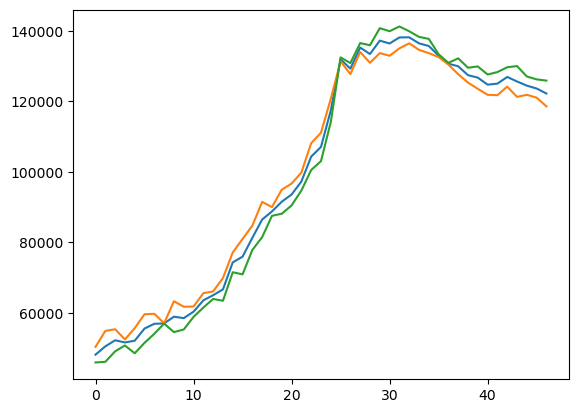

In [11]:
plt.plot(np.sum(np.abs(datad)/2,axis=(0,1)))
plt.plot(np.sum(np.abs(datad*(datad>0)),axis=(0,1)))
plt.plot(np.sum(np.abs(datad*(datad<0)),axis=(0,1)))

In [10]:
nMagnetograms

40

In [9]:
times[0:nMagnetograms]

array(['7-7-1997 14:24:04.', '7-7-1997 16:00:04.', '7-7-1997 17:36:04.',
       '7-7-1997 19:12:04.', '7-7-1997 20:48:04.', '7-7-1997 22:24:04.',
       '8-7-1997 00:00:04.', '8-7-1997 01:36:04.', '8-7-1997 03:12:04.',
       '8-7-1997 04:48:04.', '8-7-1997 06:24:04.', '8-7-1997 08:00:04.',
       '8-7-1997 09:36:04.', '8-7-1997 11:12:04.', '8-7-1997 12:48:04.',
       '8-7-1997 14:24:04.', '8-7-1997 16:00:04.', '8-7-1997 17:36:04.',
       '8-7-1997 19:12:04.', '8-7-1997 20:48:04.', '8-7-1997 22:24:04.',
       '9-7-1997 00:00:04.', '9-7-1997 01:36:04.', '9-7-1997 03:12:04.',
       '9-7-1997 04:48:04.', '9-7-1997 08:00:04.', '9-7-1997 09:36:04.',
       '9-7-1997 11:12:04.', '9-7-1997 12:48:04.', '9-7-1997 14:24:04.',
       '9-7-1997 16:00:04.', '9-7-1997 17:36:04.', '9-7-1997 19:12:04.',
       '9-7-1997 20:48:04.', '9-7-1997 22:24:04.', '10-7-1997 00:00:04',
       '10-7-1997 01:36:04', '10-7-1997 03:12:04', '10-7-1997 04:48:04',
       '10-7-1997 06:24:04'], dtype=object)